Final Project Submission

>* Student name: Tamjid Ahsan
>* Student pace: full time
>* Scheduled project review date/time: Tue, Mar 23, 2021, 05:00 PM [DST]
>* Instructor name: James Irving
>* Blog post URL:

<img src="./assets/image_1.jpg"
     alt="Logo!"
     style="float: center; margin-center: 2px;">

# Overview

A handful of companies have defined the Hollywood film industry, dominating the US and world markets. They have weathered a world war, and a Great Depression and few moderate ones, innovated wide screen and color technologies, made peace with television, learned to exploit home video and online streaming, and are more powerful than ever before.

Most big corporations are already in this business or exploring feasibility of entry. Most of the major corporations operating only in this industry are thriving. 

# Business Problem

Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies.

I am going to try to figure out what types of films are currently performing better at the box office. I shall recommend some actionable insights based on findings of this analysis, which the head of Microsoft's new movie studio can use to help decide what type of films to create.


<img src="./assets/image_0.png"
     alt="Logo!"
     style="float: center; margin-center: 10px;">

Areas of focus:

    * movie genres.
    * probability of success based on seasonality of releases.
    * profitability of movie franchise/film series.

# The Imports

## Packages and Libraries

In [1]:
# for web scraping and API calls
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
import os
import wget
import tmdbsimple as tmdb

In [2]:
# for other parts
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
import requests
import time
from pandas.core.common import flatten
from pandasql import sqldf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import ast

In [3]:
# styling (jupyter-themes must be installed)
## https://github.com/dunovank/jupyter-themes
from jupyterthemes import jtplot
# jt -r # default
jtplot.style(theme='monokai', context='notebook', ticks='True', grid='False')

# jt -t monokai -fs 120 -tfs 120 -nfs 115 -cellw 85% -T -N -kl # my setup

In [4]:
# to see dataframe better
pd.set_option('display.max_columns', 50)

## Frequently used fuctions

In [5]:
# Number formatter
def format_number(data_value, index):
    if data_value >= 1_000_000_000:
        formatter = '${:1.1f}B'.format(data_value*0.000_000_001)
    elif data_value >= 1_000_000:
        formatter = '${:1.0f}M'.format(data_value*0.000_001)
    else:
        formatter = '${:1.0f}K'.format(data_value*0.001)
    return formatter

In [6]:
# % formatter
def format_add_percentage(data_value, index):
    formatter = '{:.0f}%'.format(data_value)
    return formatter

In [7]:
 def correlation_top_bottom(df):
    corr_df_matrix_ = df.unstack().reset_index()
    corr_df_matrix_.columns = ["feature_0", 'feature_1', 'correlation']
    corr_df_matrix_['keep'] = corr_df_matrix_.apply(
        lambda x: False if x['feature_0'] == x['feature_1'] else True, axis=1)
    corr_df_matrix_['feature_combo'] = corr_df_matrix_.apply(
        lambda x: ' and '.join(set(x[['feature_0', 'feature_1']])), axis=1)
    corr_featurs = corr_df_matrix_[corr_df_matrix_.keep][[
        'feature_combo', 'correlation'
    ]].drop_duplicates().sort_values(by='correlation', ascending=False)
    print(
        f'Positive correlations:\n\
        {corr_featurs.head(10).reset_index()}\n\n {"-"*70}\n\
        Negative correlations:\n\
        {corr_featurs.sort_values(by="correlation").head(10).reset_index()}'
    )

## API and Scraping control

Set this to `True` to perform scraping and API

```python
initialize_scraping_and_API = True
```

In [8]:
initialize_scraping_and_API = False

# The Data

* [IMDb](https://www.imdb.com/) or <i>Internet Movie Database</i> was Originally a fan-operated website, now owned and operated by IMDb.com, Inc., a subsidiary of Amazon. This is one of the most reliable sourec for any information related movies in general. It is one of the most comprehensive dataset.
* [Box Office Mojo](https://www.boxofficemojo.com/) is also a part of IMDb.com, Inc., providing indepth financial informations among other metrics.
* [TMDb](https://www.themoviedb.org/) is a reliable source for movie related information. This is a popular user editable database for movies and TV shows.

Those three were used for sourcing data for the project as those are highly reliable sources without going for any paid service for information.
            

Data is collected from [IMDB website](https://datasets.imdbws.com) from downloadables, and scraping using [selenium](https://www.selenium.dev/) .
Additional data collected from TMDb using [API](https://www.themoviedb.org/documentation/api).
Then all of them are merged to create <b>'main_df'</b>, upon which this following analysis is performed.

## From IMDb

### Dataset from website

File containing detailed movie info inside [title.basics.tsv.gz](https://datasets.imdbws.com/title.basics.tsv.gz) was downloaded from `https://datasets.imdbws.com/title.basics.tsv.gz`

### Scraping using selenium


```python
pip install selenium
```
Download webdriver from [here](https://sites.google.com/a/chromium.org/chromedriver/downloads).

In [9]:
%%time
if initialize_scraping_and_API is True:
    # initializing webdriver
    driver = webdriver.Chrome('C:/Users/tamji/Documents/PATH/chromedriver.exe')
    # connection to webpage
    base_url_string = 'https://www.boxofficemojo.com/year/world/'
    # selecting years to get
    list_of_year = np.arange(2014, 2022, 1)
    # initializing scraping
    print(f'+' * 100)
    # temp files
    file_names_ = []
    file_names_error = []
    # scraping
    for im in list_of_year:
        print(f'Working on: {im}')
        url = f'{base_url_string}{im}/'
        print(f'Getting {im} homepage')
        driver.get(url)
        table = driver.find_element_by_xpath('//*[@id="table"]/div/table[2]')
        item_href = driver.find_elements_by_class_name('a-link-normal')
        print(f'Getting {im} list items')
        item_href = [item.get_property('href') for item in item_href]
        print(f'Sorting what to keep from {im} list items')
        # filter results to target needed links
        text_to_check = 'releasegroup'
        to_keep = []
        to_discard = []
        for i in item_href:
            if text_to_check in i:
                to_keep.append(i)
            else:
                to_discard.append(i)
        print(f'Preping {im} list items for looping')
        href = to_keep # [:2] is for testing, remove this to get full data
        master_list = []
        error = []
        print(f'{im} list items are looping. Hang in there!')
        for item in href:
            try:
                driver.get(item)
                url = driver.find_element_by_xpath(
                    '//*[@id="title-summary-refiner"]/a').get_property('href')
                name = driver.find_element_by_xpath(
                    '//*[@id="a-page"]/main/div/div[1]/div[1]/div/div/div[2]/h1'
                ).text

                driver.get(url)
                year = driver.find_element_by_xpath(
                    '//*[@id="a-page"]/main/div/div[1]/div[1]/div/div/div[2]/div/h1/span'
                ).text
                worldwide = driver.find_element_by_xpath(
                    '//*[@id="a-page"]/main/div/div[3]/div[1]/div/div[3]/span[2]/span'
                ).text
                international = driver.find_element_by_xpath(
                    '//*[@id="a-page"]/main/div/div[3]/div[1]/div/div[2]/span[2]'
                ).text
                domestic = driver.find_element_by_xpath(
                    '//*[@id="a-page"]/main/div/div[3]/div[1]/div/div[1]/span[2]'
                ).text

                year_cleaned = year.strip('()')
                world_collection = worldwide[1:].replace(",", "")
                international_collection = international[1:].replace(",", "")
                domestic_collection = domestic[1:].replace(",", "")
                imdb_code = url.split('/')[4]

                temp_dict = {
                    'imdb_code': imdb_code,
                    'name': name,
                    'year': year_cleaned,
                    'world_collection': world_collection,
                    'int_collection': international_collection,
                    'dom_collection': domestic_collection,
                    'url': url
                }
                master_list.append(temp_dict)
            except:
                error.append(item)
                continue

        df = pd.DataFrame(master_list)
        file_name_df = f'{im}.csv'
        df.to_csv(file_name_df, index=False)
        dict_ = {'urls': error}
        file_name_error = f'{im}_error.csv'
        pd.DataFrame(dict_).to_csv(file_name_error, index=False)
        file_names_.append(file_name_df)
        file_names_error.append(file_name_error)
        print(f'Finished working on {im}\n')
        print(f'+' * 100)
    print(f'\n\n\nDONE Looping. Cleanig data!!!')

    combined_csv_data = pd.concat([pd.read_csv(f) for f in file_names_])
    combined_csv_data_error = pd.concat(
        [pd.read_csv(f) for f in file_names_error])

    combined_csv_data.reset_index(inplace=True)
    combined_csv_data_error.reset_index(inplace=True)

    combined_csv_data = combined_csv_data.drop(columns='index')
    combined_csv_data_error = combined_csv_data_error.drop(columns='index')

    combined_csv_data = combined_csv_data.drop_duplicates('imdb_code',
                                                          ignore_index=True)

    file_name_1 = f'{list_of_year[0]}to{list_of_year[-1]}.csv'
    file_name_2 = f'{list_of_year[0]}to{list_of_year[-1]}_error.csv'
    combined_csv_data.to_csv(file_name_1, index=False)
    combined_csv_data_error.to_csv(file_name_2, index=False)

    print(f'\n\n\nDONE!!!')
    print(f'+' * 100)
    print(f'+' * 100)
# leaves temp files behind

Wall time: 0 ns


In [10]:
# moving major files
if initialize_scraping_and_API is True:
    destination_1 = f'./Data/bom_{file_name_1}'
    destination_2 = f'./Data/temp/{file_name_2}'
    os.rename(file_name_1,destination_1)
    os.rename(file_name_2,destination_2)

In [11]:
def move_files(file):
    destination = f'./Data/temp/{file}'
    os.rename(file,destination)

In [12]:
# moving temp files
if initialize_scraping_and_API is True:
    if True:
        [move_files(f) for f in file_names_]
        [move_files(f) for f in file_names_error]
        print('Done moving!!')

Note: ***repo does not include temp files***

## From TMDb API

In [13]:
# load json
if initialize_scraping_and_API is True:
    def get_keys(path):
        with open(path) as f:
            return json.load(f)

In [14]:
# api key initialize
if initialize_scraping_and_API is True:
    keys = get_keys("/Users/tamji/.secret/tmdb_api.json")
    api_key = keys['api_key']

In [15]:
if initialize_scraping_and_API is True:
    tmdb.API_KEY = api_key

In [16]:
# movie_main_df_sliced is cleaned beforehand
if initialize_scraping_and_API is True:
    # for matching imdb titles 
    movie_titles_df = pd.read_csv(r'./Data/movie_main_df_sliced.csv',
                                  usecols=["tconst"])

In [17]:
# preparing loaded data for use
if initialize_scraping_and_API is True:
    imdb_titles = list(flatten(movie_titles_df.values.tolist()))

In [18]:
# get how much data is incoming
if initialize_scraping_and_API is True:
    len(imdb_titles)

In [19]:
# empty df to store results
if initialize_scraping_and_API is True:
    df = pd.DataFrame()

In [20]:
if initialize_scraping_and_API is True:
    for imdb_id in imdb_titles:    
        try:
            movie = tmdb.Movies(imdb_id)
            response = movie.info()
            df = df.append(pd.json_normalize(movie.info()))
        except:
            pass

In [21]:
if initialize_scraping_and_API is True:
    df = df.reset_index()

In [22]:
if initialize_scraping_and_API is True:
    df = df.drop(columns=['index'])

In [23]:
if initialize_scraping_and_API is True:
    df.to_csv(r'./Data/tmdb_parsd.csv')

# Preparing datasets

## IMDb

### loading

In [24]:
%%time
df_1 = pd.read_csv(r'./Data/data.tsv',
                   delimiter='\t',
                   low_memory=False)

Wall time: 17.3 s


### inspecting

In [25]:
df_1.head(3)

tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              4  Animation,Comedy,Romance

In [26]:
df_1['titleType'].value_counts()

tvEpisode       5590798
short            799028
movie            570678
video            297824
tvSeries         203184
tvMovie          130415
tvMiniSeries      36270
tvSpecial         31753
videoGame         27529
tvShort            9611
audiobook             1
radioSeries           1
episode               1
Name: titleType, dtype: int64

### cleaning

In [27]:
%%time
# slicing to keep only movies
movie_df = df_1[df_1['titleType'] == 'movie']
# droping adult titles
movie_df = movie_df[movie_df['isAdult'] == '0']
# handeling nan values
movie_df.loc[movie_df['runtimeMinutes'] == r'\N', 'runtimeMinutes'] = np.nan
movie_df.loc[movie_df['startYear'] == r'\N', 'startYear'] = np.nan
movie_df.loc[movie_df['genres'] == r'\N', 'genres'] = np.nan
# setting nan genere to NoInfo
movie_df.loc[movie_df['genres'].isna(), 'genres'] = "NoInfo"
# nan value droping for start year
movie_df = movie_df[~movie_df['startYear'].isna()]

movie_df = movie_df.reset_index()
movie_df = movie_df.drop(['index', 'titleType', 'endYear', 'isAdult'], axis=1)

movie_df.to_csv(r'./Data/movie_df.csv', index=False)
movie_df

Wall time: 2.38 s


tconst                                       primaryTitle  \
0       tt0000502                                           Bohemios   
1       tt0000574                        The Story of the Kelly Gang   
2       tt0000615                                 Robbery Under Arms   
3       tt0000630                                             Hamlet   
4       tt0000675                                        Don Quijote   
...           ...                                                ...   
490999  tt9916622        Rodolpho Teóphilo - O Legado de um Pioneiro   
491000  tt9916680  De la ilusión al desconcierto: cine colombiano...   
491001  tt9916706                                    Dankyavar Danka   
491002  tt9916730                                             6 Gunn   
491003  tt9916754                     Chico Albuquerque - Revelações   

                                            originalTitle startYear  \
0                                                Bohemios      1905   
1                             The Story of the Kelly Gang      1906   
2                                      Robbery Under Arms      1907   
3                                                  Amleto      1908   
4                                             Don Quijote      1908   
...                                                   ...       ...   
490999        Rodolpho Teóphilo - O Legado de um Pioneiro      2015   
491000  De la ilusión al desconcierto: cine colombiano...      2007   
491001                                    Dankyavar Danka      2013   
491002                                             6 Gunn      2017   
491003                     Chico Albuquerque - Revelações      2013   

       runtimeMinutes                      genres  
0                 100                      NoInfo  
1                  70  Action,Adventure,Biography  
2                 NaN                       Drama  
3                 NaN                       Drama  
4                 NaN                       Drama  
...               ...                         ...  
490999             57                 Documentary  
491000            100                 Documentary  
491001            NaN                      Comedy  
491002            116                      NoInfo  
491003             49                 Documentary  

[491004 rows x 6 columns]

splitting genere

In [28]:
%%time
# getting preliminary unique list for cleaning
genres = list(movie_df['genres'].unique())
# temp list to store list of splited genre
genre_cleaning_temp = []
# getting list of splited genre
for item in genres:
    # for dealing with nan
    if type(item) is not float:
        # actual spliting
        genre_split = item.split(",")
        # appending
        genre_cleaning_temp.extend(genre_split)
# geting unique list
from pandas.core.common import flatten
# flattening temp list
## https://stackoverflow.com/questions/12897374/get-unique-values-from-a-list-in-python by https://stackoverflow.com/users/2062318/todor ##
## https://saralgyaan.com/posts/nested-list-to-list-python-in-just-three-lines-of-code/ ##
genre_cleaning_temp = list(flatten(genre_cleaning_temp))
# unique genre list
unique_genre = list(dict.fromkeys(genre_cleaning_temp))

## overly complicated way, theres much simpler method out in the wild.
unique_genre

Wall time: 31.1 ms


['NoInfo',
 'Action',
 'Adventure',
 'Biography',
 'Drama',
 'Fantasy',
 'Comedy',
 'War',
 'Documentary',
 'Crime',
 'Romance',
 'Family',
 'History',
 'Sci-Fi',
 'Thriller',
 'Western',
 'Short',
 'Sport',
 'Mystery',
 'Horror',
 'Music',
 'Animation',
 'Musical',
 'Film-Noir',
 'News',
 'Adult',
 'Reality-TV',
 'Game-Show',
 'Talk-Show']

In [29]:
%%time
#boolian matrix for all genere
movie_genre_df = pd.DataFrame([[(x in y) for x in unique_genre]
                               for y in movie_df['genres']],
                              columns=unique_genre)

Wall time: 2.43 s


In [30]:
# merging
movie_main_df = pd.concat([movie_df, movie_genre_df], axis=1)

In [31]:
# enforcing dtypes
movie_main_df = movie_main_df.convert_dtypes()

In [32]:
movie_main_df.shape

(491004, 35)

In [33]:
movie_main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491004 entries, 0 to 491003
Data columns (total 35 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          491004 non-null  string 
 1   primaryTitle    491004 non-null  string 
 2   originalTitle   491004 non-null  string 
 3   startYear       491004 non-null  string 
 4   runtimeMinutes  348729 non-null  string 
 5   genres          491004 non-null  string 
 6   NoInfo          491004 non-null  boolean
 7   Action          491004 non-null  boolean
 8   Adventure       491004 non-null  boolean
 9   Biography       491004 non-null  boolean
 10  Drama           491004 non-null  boolean
 11  Fantasy         491004 non-null  boolean
 12  Comedy          491004 non-null  boolean
 13  War             491004 non-null  boolean
 14  Documentary     491004 non-null  boolean
 15  Crime           491004 non-null  boolean
 16  Romance         491004 non-null  boolean
 17  Family    

In [34]:
movie_main_df.describe()

tconst primaryTitle originalTitle startYear runtimeMinutes  genres  \
count      491004       491004        491004    491004         348729  491004   
unique     491004       435498        444525       133            470    1317   
top     tt3173562       Mother          Home      2017             90   Drama   
freq            1           40            36     17755          23507   90267   

        NoInfo  Action Adventure Biography   Drama Fantasy  Comedy     War  \
count   491004  491004    491004    491004  491004  491004  491004  491004   
unique       2       2         2         2       2       2       2       2   
top      False   False     False     False   False   False   False   False   
freq    424787  450544    468879    478159  309787  480389  404506  483095   

       Documentary   Crime Romance  Family History  Sci-Fi Thriller Western  \
count       491004  491004  491004  491004  491004  491004   491004  491004   
unique           2       2       2       2       2       2        2       2   
top          False   False   False   False   False   False    False   False   
freq        393223  461821  451561  476778  479702  482990   463182  484426   

         Short   Sport Mystery  Horror   Music Animation Musical Film-Noir  \
count   491004  491004  491004  491004  491004    491004  491004    491004   
unique       2       2       2       2       2         2       2         2   
top      False   False   False   False   False     False   False     False   
freq    490966  485607  478308  467678  472317    484749  482077    490222   

          News   Adult Reality-TV Game-Show Talk-Show  
count   491004  491004     491004    491004    491004  
unique       2       2          2         2         2  
top      False   False      False     False     False  
freq    489618  490968     490625    490989    490894

In [35]:
movie_main_df['startYear'] = movie_main_df['startYear'].astype('int')
movie_main_df['runtimeMinutes'].fillna('0', inplace=True)
movie_main_df['runtimeMinutes'] = movie_main_df['runtimeMinutes'].astype('int')

In [36]:
movie_main_df['startYear'].sort_values().unique()

array([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906,
       1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917,
       1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928,
       1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027,
       2028])

### choosing features

*****Choosing to focus analysis on movies released between 2015 to 2020, where primary spoken language is English.*****

- In my opinion this is the most appropriate time frame to focus, as this gives enough data for analysis and at the same time does not include old info which will not be good representative of the current market situation. As customer/viewer taste and market trends shift over the time.

- Microsoft should focus only on releasing content in <b>English</b> for their kick-off. This gives them enough exposure and get noticed as a big player in the game, as they intend to be. Although they should focus on other territory to explore as there are ample opportunities left untapped. For example, in 2020 China surpassed North America in terms of industry value.\
As Microsoft has business across the globe, this should be relatively straight forward for them.

- I am also choosing not to focus on <b>ultra-low</b> budget movies for this analysis. Microsoft is one of the biggest corporations on earth. They have financial support to go for the big studios.
- I am also not including <b>'Documentary', 'Short', 'Adult', 'Reality-TV', 'Game-Show', 'Talk-Show', 'News', 'Film-Noir'</b> titles. Those are entirely different class of product to be compared with conventional movies.

In [37]:
# filtering based on year, keeping one addtional year just to be safe
movie_main_df_sliced = movie_main_df[(movie_main_df['startYear'] >= 2014)
                                     & (movie_main_df['startYear'] <= 2021)]

In [38]:
movie_main_df_sliced.describe()

startYear  runtimeMinutes
count  123293.000000   123293.000000
mean     2017.221789       68.234523
std         2.117191      100.801411
min      2014.000000        0.000000
25%      2015.000000       45.000000
50%      2017.000000       80.000000
75%      2019.000000       96.000000
max      2021.000000    28643.000000

In [39]:
to_drop = [
    'Documentary', 'Short', 'Adult', 'Reality-TV', 'Game-Show', 'Talk-Show',
    'News', 'Film-Noir'
]

In [40]:
for item in to_drop:
    movie_main_df_sliced = movie_main_df_sliced[~movie_main_df_sliced[item].
                                                eq(1)]

In [41]:
movie_main_df_sliced

tconst                               primaryTitle  \
5089    tt0011216                             Spanish Fiesta   
5560    tt0011801                           Tötet nicht mehr   
9809    tt0016906                                 Frivolinas   
45545   tt0062336  El Tango del Viudo y Su Espejo Deformante   
50362   tt0069049                 The Other Side of the Wind   
...           ...                                        ...   
490995  tt9916270                   Il talento del calabrone   
490996  tt9916362                                      Coven   
490997  tt9916428                        The Secret of China   
490998  tt9916538                        Kuambil Lagi Hatiku   
491002  tt9916730                                     6 Gunn   

                                    originalTitle  startYear  runtimeMinutes  \
5089                            La fête espagnole       2019              67   
5560                             Tötet nicht mehr       2019               0   
9809                                   Frivolinas       2014              80   
45545   El Tango del Viudo y Su Espejo Deformante       2020              70   
50362                  The Other Side of the Wind       2018             122   
...                                           ...        ...             ...   
490995                   Il talento del calabrone       2020              84   
490996                                   Akelarre       2020              90   
490997               Hong xing zhao yao Zhong guo       2019               0   
490998                        Kuambil Lagi Hatiku       2019             123   
491002                                     6 Gunn       2017             116   

                         genres  NoInfo  Action  Adventure  Biography  Drama  \
5089                      Drama   False   False      False      False   True   
5560               Action,Crime   False    True      False      False  False   
9809             Comedy,Musical   False   False      False      False  False   
45545                     Drama   False   False      False      False   True   
50362                     Drama   False   False      False      False   True   
...                         ...     ...     ...        ...        ...    ...   
490995                 Thriller   False   False      False      False  False   
490996  Adventure,Drama,History   False   False       True      False   True   
490997    Adventure,History,War   False   False       True      False  False   
490998                    Drama   False   False      False      False   True   
491002                   NoInfo    True   False      False      False  False   

        Fantasy  Comedy    War  Documentary  Crime  Romance  Family  History  \
5089      False   False  False        False  False    False   False    False   
5560      False   False  False        False   True    False   False    False   
9809      False    True  False        False  False    False   False    False   
45545     False   False  False        False  False    False   False    False   
50362     False   False  False        False  False    False   False    False   
...         ...     ...    ...          ...    ...      ...     ...      ...   
490995    False   False  False        False  False    False   False    False   
490996    False   False  False        False  False    False   False     True   
490997    False   False   True        False  False    False   False     True   
490998    False   False  False        False  False    False   False    False   
491002    False   False  False        False  False    False   False    False   

        Sci-Fi  Thriller  Western  Short  Sport  Mystery  Horror  Music  \
5089     False     False    False  False  False    False   False  False   
5560     False     False    False  False  False    False   False  False   
9809     False     False    False  False  False    False   False   True   
45545    False     False    False  False  False    False   

In [42]:
movie_main_df_sliced.to_csv('./Data/movie_main_df_sliced.csv',index = False)

## Merging all sources

In [43]:
# loading datasets
imdb_df = pd.read_csv('./Data/movie_main_df_sliced.csv')
bom_df = pd.read_csv('./Data/bom_2014to2021.csv')
tmdb_df = pd.read_csv('./Data/tmdb_parsd.csv')

merge_1

In [44]:
merge_1 = pd.merge(imdb_df,
                   bom_df,
                   how='left',
                   left_on='tconst',
                   right_on='imdb_code')

In [45]:
merge_1

tconst                               primaryTitle  \
0      tt0011216                             Spanish Fiesta   
1      tt0011801                           Tötet nicht mehr   
2      tt0016906                                 Frivolinas   
3      tt0062336  El Tango del Viudo y Su Espejo Deformante   
4      tt0069049                 The Other Side of the Wind   
...          ...                                        ...   
84541  tt9916270                   Il talento del calabrone   
84542  tt9916362                                      Coven   
84543  tt9916428                        The Secret of China   
84544  tt9916538                        Kuambil Lagi Hatiku   
84545  tt9916730                                     6 Gunn   

                                   originalTitle  startYear  runtimeMinutes  \
0                              La fête espagnole       2019              67   
1                               Tötet nicht mehr       2019               0   
2                                     Frivolinas       2014              80   
3      El Tango del Viudo y Su Espejo Deformante       2020              70   
4                     The Other Side of the Wind       2018             122   
...                                          ...        ...             ...   
84541                   Il talento del calabrone       2020              84   
84542                                   Akelarre       2020              90   
84543               Hong xing zhao yao Zhong guo       2019               0   
84544                        Kuambil Lagi Hatiku       2019             123   
84545                                     6 Gunn       2017             116   

                        genres  NoInfo  Action  Adventure  Biography  Drama  \
0                        Drama   False   False      False      False   True   
1                 Action,Crime   False    True      False      False  False   
2               Comedy,Musical   False   False      False      False  False   
3                        Drama   False   False      False      False   True   
4                        Drama   False   False      False      False   True   
...                        ...     ...     ...        ...        ...    ...   
84541                 Thriller   False   False      False      False  False   
84542  Adventure,Drama,History   False   False       True      False   True   
84543    Adventure,History,War   False   False       True      False  False   
84544                    Drama   False   False      False      False   True   
84545                   NoInfo    True   False      False      False  False   

       Fantasy  Comedy    War  Documentary  Crime  Romance  Family  History  \
0        False   False  False        False  False    False   False    False   
1        False   False  False        False   True    False   False    False   
2        False    True  False        False  False    False   False    False   
3        False   False  False        False  False    False   False    False   
4        False   False  False        False  False    False   False    False   
...        ...     ...    ...          ...    ...      ...     ...      ...   
84541    False   False  False        False  False    False   False    False   
84542    False   False  False        False  False    False   False     True   
84543    False   False   True        False  False    False   False     True   
84544    False   False  False        False  False    False   False    False   
84545    False   False  False        False  False    False   False    False   

       Sci-Fi  Thriller  Western  Short  Sport  Mystery  Horror  Music  \
0       False     False    False  False  False    False   False  False   
1       False     False    False  False  False    False   False  False   
2       False     False    False  False  False    False   False   True   
3       False     False    False  False  False    False   False  False   
4       False     False    False  Fa

prepping for merge 2

In [46]:
tmdb_df = tmdb_df.drop(tmdb_df.columns[0:4], axis=1)

In [47]:
tmdb_df.columns

Index(['budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'belongs_to_collection.id',
       'belongs_to_collection.name', 'belongs_to_collection.poster_path',
       'belongs_to_collection.backdrop_path'],
      dtype='object')

In [48]:
filter_list = [
    'imdb_id', 'title', 'revenue', 'budget', 'release_date',
    'production_companies', 'popularity', 'vote_average', 'vote_count',
    'overview', 'belongs_to_collection.name', 'original_language'
]

In [49]:
tmdb_df_reduced = tmdb_df[filter_list]

merge 2

In [50]:
merge_2 = pd.merge(merge_1,
                   tmdb_df_reduced,
                   how='inner',
                   left_on='tconst',
                   right_on='imdb_id')

In [51]:
df = merge_2.copy()

In [52]:
df.columns

Index(['tconst', 'primaryTitle', 'originalTitle', 'startYear',
       'runtimeMinutes', 'genres', 'NoInfo', 'Action', 'Adventure',
       'Biography', 'Drama', 'Fantasy', 'Comedy', 'War', 'Documentary',
       'Crime', 'Romance', 'Family', 'History', 'Sci-Fi', 'Thriller',
       'Western', 'Short', 'Sport', 'Mystery', 'Horror', 'Music', 'Animation',
       'Musical', 'Film-Noir', 'News', 'Adult', 'Reality-TV', 'Game-Show',
       'Talk-Show', 'imdb_code', 'name', 'year', 'world_collection',
       'int_collection', 'dom_collection', 'url', 'imdb_id', 'title',
       'revenue', 'budget', 'release_date', 'production_companies',
       'popularity', 'vote_average', 'vote_count', 'overview',
       'belongs_to_collection.name', 'original_language'],
      dtype='object')

cleaning

In [53]:
rearrange = [
    'tconst', 'imdb_code', 'imdb_id', 'primaryTitle', 'originalTitle', 'name',
    'title', 'startYear', 'year', 'release_date', 'runtimeMinutes', 'budget',
    'revenue', 'world_collection', 'int_collection', 'dom_collection',
    'production_companies', 'popularity', 'vote_average', 'vote_count',
    'overview', 'belongs_to_collection.name', 'original_language', 'genres', 'NoInfo', 'Action',
    'Adventure', 'Biography', 'Drama', 'Fantasy', 'Comedy', 'War', 'Crime',
    'Romance', 'Family', 'History', 'Sci-Fi', 'Thriller', 'Western', 'Sport',
    'Mystery', 'Horror', 'Music', 'Animation', 'Musical', 'url'
]
df = df[rearrange]

filtering order: 
1. financial data
2. year
3.  review data


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44353 entries, 0 to 44352
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tconst                      44353 non-null  object 
 1   imdb_code                   13351 non-null  object 
 2   imdb_id                     44353 non-null  object 
 3   primaryTitle                44353 non-null  object 
 4   originalTitle               44353 non-null  object 
 5   name                        13351 non-null  object 
 6   title                       44353 non-null  object 
 7   startYear                   44353 non-null  int64  
 8   year                        13351 non-null  float64
 9   release_date                42437 non-null  object 
 10  runtimeMinutes              44353 non-null  int64  
 11  budget                      44353 non-null  int64  
 12  revenue                     44353 non-null  int64  
 13  world_collection            133

In [55]:
df.describe()

startYear          year  runtimeMinutes        budget       revenue  \
count  44353.000000  13351.000000    44353.000000  4.435300e+04  4.435300e+04   
mean    2017.107704   2016.916411       88.849976  1.462749e+06  4.188408e+06   
std        2.025922      1.846724       36.046684  1.175852e+07  4.898516e+07   
min     2014.000000   2014.000000        0.000000  0.000000e+00  0.000000e+00   
25%     2015.000000   2015.000000       81.000000  0.000000e+00  0.000000e+00   
50%     2017.000000   2017.000000       92.000000  0.000000e+00  0.000000e+00   
75%     2019.000000   2018.000000      106.000000  0.000000e+00  0.000000e+00   
max     2021.000000   2021.000000     1260.000000  3.560000e+08  2.797801e+09   

       world_collection  int_collection  dom_collection    popularity  \
count      1.335100e+04    1.264600e+04    3.289000e+03  44353.000000   
mean       1.722414e+07    1.279721e+07    2.060086e+07      5.966112   
std        9.106972e+07    6.373112e+07    6.311116e+07     40.339807   
min        2.000000e+00    2.000000e+00    4.900000e+01      0.000000   
25%        3.873450e+04    4.289450e+04    3.447100e+04      0.600000   
50%        3.877660e+05    4.062780e+05    3.423700e+05      1.513000   
75%        3.320476e+06    3.206889e+06    8.106986e+06      5.705000   
max        2.797501e+09    1.939128e+09    9.366622e+08   5227.005000   

       vote_average    vote_count  
count  44353.000000  44353.000000  
mean       3.952096    101.957252  
std        3.108509    742.014378  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        5.000000      2.000000  
75%        6.400000     10.000000  
max       10.000000  25252.000000

In [56]:
df['revenue'].sort_values().value_counts() # null values are stored as 0

0            41364
10000           27
100000          21
1500000         17
500              9
             ...  
147315           1
15894372         1
42972994         1
117813057        1
158162788        1
Name: revenue, Length: 2721, dtype: int64

Choosing greater value among two data sources for revenue, then cleaning noises.

In [57]:
df['world_collection'].isna().value_counts()

True     31002
False    13351
Name: world_collection, dtype: int64

In [58]:
((df['revenue']!=0)&(df['world_collection'].isna())).value_counts()

False    44003
True       350
dtype: int64

In [59]:
condition_1 = (df['revenue']!=0)

In [60]:
condition_2 = ~df['world_collection'].isna()

In [61]:
df = df[condition_1 | condition_2]

In [62]:
df

tconst  imdb_code    imdb_id                 primaryTitle  \
5      tt0100275  tt0100275  tt0100275     The Wandering Soap Opera   
22     tt0315642  tt0315642  tt0315642                        Wazir   
26     tt0331314  tt0331314  tt0331314              Bunyan and Babe   
32     tt0365907  tt0365907  tt0365907  A Walk Among the Tombstones   
33     tt0369610  tt0369610  tt0369610               Jurassic World   
...          ...        ...        ...                          ...   
44331  tt9908390  tt9908390  tt9908390                      Le lion   
44333  tt9908960  tt9908960  tt9908960                      Pliusas   
44339  tt9911196  tt9911196  tt9911196          The Marriage Escape   
44347  tt9914942  tt9914942  tt9914942   La vida sense la Sara Amat   
44352  tt9916428  tt9916428  tt9916428          The Secret of China   

                        originalTitle                         name  \
5               La Telenovela Errante     The Wandering Soap Opera   
22                              Wazir                        Wazir   
26                    Bunyan and Babe              Bunyan and Babe   
32        A Walk Among the Tombstones  A Walk Among the Tombstones   
33                     Jurassic World               Jurassic World   
...                               ...                          ...   
44331                         Le lion                      Le lion   
44333                         Pliusas                      Pliusas   
44339  De beentjes van Sint-Hildegard          The Marriage Escape   
44347      La vida sense la Sara Amat   La vida sense la Sara Amat   
44352    Hong xing zhao yao Zhong guo          The Secret of China   

                             title  startYear    year release_date  \
5         The Wandering Soap Opera       2017  2017.0   2017-08-10   
22                           Wazir       2016  2016.0   2016-01-07   
26                 Bunyan and Babe       2017  2017.0   2017-01-12   
32     A Walk Among the Tombstones       2014  2014.0   2014-09-18   
33                  Jurassic World       2015  2015.0   2015-06-06   
...                            ...        ...     ...          ...   
44331                     The Lion       2020  2020.0   2020-01-29   
44333                      Pliusas       2018  2018.0   2018-09-07   
44339          The Marriage Escape       2020  2020.0   2020-02-10   
44347   La vida sense la Sara Amat       2019  2019.0   2019-07-12   
44352          The Secret of China       2019  2019.0   2019-08-08   

       runtimeMinutes     budget     revenue  world_collection  \
5                  80          0           0      3.624000e+03   
22                103    5200000     9200000      5.633588e+06   
26                 84          0           0      7.206000e+04   
32                114   28000000    53181600      5.883438e+07   
33                124  150000000  1671713208      1.670516e+09   
...               ...        ...         ...               ...   
44331              95          0           0      3.507711e+06   
44333              90          0           0      7.463700e+04   
44339             103          0           0      7.760946e+06   
44347              74          0           0      5.979400e+04   
44352               0          0           0      4.408165e+06   

       int_collection  dom_collection  \
5                 NaN          3624.0   
22       4.509543e+06       1124045.0   
26       7.206000e+04             NaN   
32       3.252678e+07      26307600.0   
33       1.018131e+09     652385625.0   
...               ...             ...   
44331    3.507711e+06             NaN   
44333    7.463700e+04             NaN   
44339    7.760946e+06             NaN   
44347    5.979400e+04             NaN   
44352    4.408165e+06             NaN   

                                    production_companies  popularity  \
5      [{'id': 96241, 'logo_path': None, 'name': 'Poe...       1.400   
22     [{'id': 12865, 'logo_path': None, 'nam

In [63]:
# selecting max value as budget
df.loc[:,['world_collection']] = df[['revenue','world_collection']].max(axis=1)

In [64]:
# redundent data droping
drop_list = [
    'tconst', 'imdb_code', 'index','name', 'title', 'year', 'revenue', 'url'
]

In [65]:
df = df.reset_index()

In [66]:
df = df.drop(columns=drop_list)

In [67]:
df["release_date"] = pd.to_datetime(df["release_date"]) 

dealing with nested data

In [68]:
# creating a copy of df
df1 = df.copy()

In [69]:
# getting a slice to work on 
df1 = df1[['imdb_id','production_companies']]

In [70]:
df1_dict=df1.to_dict()

In [71]:
df1_dict.keys()

dict_keys(['imdb_id', 'production_companies'])

In [72]:
# https://stackoverflow.com/questions/39807724/extract-python-dictionary-from-string by https://stackoverflow.com/users/3734244/danidee

In [73]:
def get_list(string):
    x = ast.literal_eval(re.search('({.+})', string).group(0))
    return x

In [74]:
temp = [] #store temp dicts
ty = [] #catch errors
for item in df1_dict['production_companies']:
    x = df1_dict['production_companies'][item]
    try:
        temp.append(get_list(x))
    except:
        temp.append(ty)

In [75]:
#lopping through temp dicts and extracting production house name
temp_li = []

for i in temp:
    if type(i) == tuple:
        lli = []
        for y in i:
            lli.append(y['name'])
        code = ', '.join(lli)
        temp_dict = {
            'production_comp': code,
        }   
        temp_li.append(temp_dict)
    elif type(i) == dict:

        code = i['name']
        temp_dict = {
            'production_comp': code,
        }   
        temp_li.append(temp_dict)

    elif type(i) == list:

        code = 'Others,No info'
        temp_dict = {
                    'production_comp': code,
                }    
        temp_li.append(temp_dict)

In [76]:
pro = pd.DataFrame.from_dict(temp_li)

In [77]:
pro_1=pd.concat([df1.reset_index(),pro],axis=1)

In [78]:
pro_1=pro_1.drop(axis=1, columns=['index','production_companies'])

In [79]:
df_final = pd.merge(df, pro_1, left_on='imdb_id', right_on='imdb_id')

- touchup

In [80]:
df_final.head(4)

imdb_id                 primaryTitle                originalTitle  \
0  tt0100275     The Wandering Soap Opera        La Telenovela Errante   
1  tt0315642                        Wazir                        Wazir   
2  tt0331314              Bunyan and Babe              Bunyan and Babe   
3  tt0365907  A Walk Among the Tombstones  A Walk Among the Tombstones   

   startYear release_date  runtimeMinutes    budget  world_collection  \
0       2017   2017-08-10              80         0            3624.0   
1       2016   2016-01-07             103   5200000         9200000.0   
2       2017   2017-01-12              84         0           72060.0   
3       2014   2014-09-18             114  28000000        58834384.0   

   int_collection  dom_collection  \
0             NaN          3624.0   
1       4509543.0       1124045.0   
2         72060.0             NaN   
3      32526784.0      26307600.0   

                                production_companies  popularity  \
0  [{'id': 96241, 'logo_path': None, 'name': 'Poe...       1.400   
1  [{'id': 12865, 'logo_path': None, 'name': 'Get...       5.191   
2  [{'id': 87468, 'logo_path': None, 'name': 'Too...      20.049   
3  [{'id': 39043, 'logo_path': None, 'name': 'Tra...      34.302   

   vote_average  vote_count  \
0           6.5           9   
1           6.6          90   
2           6.2          15   
3           6.3        2129   

                                            overview  \
0  The film revolves around the concept of soap o...   
1  'Wazir' is a tale of two unlikely friends, a w...   
2  Travis and his sister, Whitney, visit their gr...   
3  Private investigator Matthew Scudder is hired ...   

  belongs_to_collection.name original_language                      genres  \
0                        NaN                es        Comedy,Drama,Fantasy   
1                        NaN                hi          Action,Crime,Drama   
2                        NaN                en  Adventure,Animation,Comedy   
3                        NaN                en          Action,Crime,Drama   

   NoInfo  Action  Adventure  Biography  Drama  Fantasy  Comedy    War  Crime  \
0   False   False      False      False   True     True    True  False  False   
1   False    True      False      False   True    False   False  False   True   
2   False   False       True      False  False    False    True  False  False   
3   False    True      False      False   True    False   False  False   True   

   Romance  Family  History  Sci-Fi  Thriller  Western  Sport  Mystery  \
0    False   False    False   False     False    False  False    False   
1    False   False    False   False     False    False  False    False   
2    False   False    False   False     False    False  False    False   
3    False   False    False   False     False    False  False    False   

   Horror  Music  Animation  Musical  \
0   False  False      False    False   
1   False  False      False    False   
2   False  False       True    False   
3   False  False      False    False   

                                     production_comp  
0                               Poetastros, Suricato  
1  Getaway Films Private Limited, Vinod Chopra Fi...  
2             Toonz Entertainment, Exodus Film Group  
3  Traveling Picture Show Company (TPSC), Jersey ...

In [81]:
df_final.columns

Index(['imdb_id', 'primaryTitle', 'originalTitle', 'startYear', 'release_date',
       'runtimeMinutes', 'budget', 'world_collection', 'int_collection',
       'dom_collection', 'production_companies', 'popularity', 'vote_average',
       'vote_count', 'overview', 'belongs_to_collection.name',
       'original_language', 'genres', 'NoInfo', 'Action', 'Adventure',
       'Biography', 'Drama', 'Fantasy', 'Comedy', 'War', 'Crime', 'Romance',
       'Family', 'History', 'Sci-Fi', 'Thriller', 'Western', 'Sport',
       'Mystery', 'Horror', 'Music', 'Animation', 'Musical',
       'production_comp'],
      dtype='object')

In [82]:
df_final=df_final.drop(columns='production_companies')

In [83]:
rearrange_ = [
    'imdb_id', 'primaryTitle', 'originalTitle', 'startYear', 'release_date',
       'runtimeMinutes', 'budget', 'world_collection', 'int_collection',
       'dom_collection', 'popularity', 'vote_average',
       'vote_count', 'production_comp', 'original_language','belongs_to_collection.name',
        'genres', 'NoInfo', 'Action', 'Adventure',
       'Biography', 'Drama', 'Fantasy', 'Comedy', 'War', 'Crime', 'Romance',
       'Family', 'History', 'Sci-Fi', 'Thriller', 'Western', 'Sport',
       'Mystery', 'Horror', 'Music', 'Animation', 'Musical',
       'overview'
]

In [84]:
df_final = df_final[rearrange_]

In [85]:
df_final

imdb_id                 primaryTitle                   originalTitle  \
0      tt0100275     The Wandering Soap Opera           La Telenovela Errante   
1      tt0315642                        Wazir                           Wazir   
2      tt0331314              Bunyan and Babe                 Bunyan and Babe   
3      tt0365907  A Walk Among the Tombstones     A Walk Among the Tombstones   
4      tt0369610               Jurassic World                  Jurassic World   
...          ...                          ...                             ...   
13696  tt9908390                      Le lion                         Le lion   
13697  tt9908960                      Pliusas                         Pliusas   
13698  tt9911196          The Marriage Escape  De beentjes van Sint-Hildegard   
13699  tt9914942   La vida sense la Sara Amat      La vida sense la Sara Amat   
13700  tt9916428          The Secret of China    Hong xing zhao yao Zhong guo   

       startYear release_date  runtimeMinutes     budget  world_collection  \
0           2017   2017-08-10              80          0      3.624000e+03   
1           2016   2016-01-07             103    5200000      9.200000e+06   
2           2017   2017-01-12              84          0      7.206000e+04   
3           2014   2014-09-18             114   28000000      5.883438e+07   
4           2015   2015-06-06             124  150000000      1.671713e+09   
...          ...          ...             ...        ...               ...   
13696       2020   2020-01-29              95          0      3.507711e+06   
13697       2018   2018-09-07              90          0      7.463700e+04   
13698       2020   2020-02-10             103          0      7.760946e+06   
13699       2019   2019-07-12              74          0      5.979400e+04   
13700       2019   2019-08-08               0          0      4.408165e+06   

       int_collection  dom_collection  popularity  vote_average  vote_count  \
0                 NaN          3624.0       1.400           6.5           9   
1        4.509543e+06       1124045.0       5.191           6.6          90   
2        7.206000e+04             NaN      20.049           6.2          15   
3        3.252678e+07      26307600.0      34.302           6.3        2129   
4        1.018131e+09     652385625.0      63.489           6.6       16595   
...               ...             ...         ...           ...         ...   
13696    3.507711e+06             NaN      57.734           5.3         101   
13697    7.463700e+04             NaN       0.600           7.0           1   
13698    7.760946e+06             NaN       4.372           8.5           8   
13699    5.979400e+04             NaN       1.940           7.4           5   
13700    4.408165e+06             NaN       0.651           7.0           1   

                                         production_comp original_language  \
0                                   Poetastros, Suricato                es   
1      Getaway Films Private Limited, Vinod Chopra Fi...                hi   
2                 Toonz Entertainment, Exodus Film Group                en   
3      Traveling Picture Show Company (TPSC), Jersey ...                en   
4      Amblin Entertainment, Legendary Pictures, Univ...                en   
...                                                  ...               ...   
13696  TF1 Studio, Monkey Pack Films, Pathé!, TF1 Fil...                fr   
13697                                     Others,No info                lt   
13698                                     Others,No info                nl   
13699                             Massa d'Or Produccions                ca   
13700                                     Others,No info                zh   

      belongs_to_collection.name                      genres  NoInfo  Action  \
0                            NaN        Comedy,Drama,Fantasy   False   False   
1                            NaN          Action,Crim

In [86]:
df_final.to_csv('./Data/main_df.csv', index=False)

## Working on main_df

### prepping for analysis, furthur cleaning

In [87]:
main_df_raw = pd.read_csv(r'./Data/main_df.csv',
                          parse_dates=['release_date'],
                          low_memory=False)

In [88]:
main_df=main_df_raw.iloc[:,0:17] #droping boolean columns

In [89]:
main_df=main_df[~main_df.release_date.isna()]

In [90]:
main_df['release_year'] = main_df['release_date'].dt.year
main_df['release_year'].astype('int')

0        2017
1        2016
2        2017
3        2014
4        2015
         ... 
13696    2020
13697    2018
13698    2020
13699    2019
13700    2019
Name: release_year, Length: 13620, dtype: int32

Focusing my analysis from 2015 to end of 2020. Inputs below can be changed to focus any timeframe from 2007 to March 12, 2021. Data is in safe folder inside repo.

In [91]:
main_df = main_df[(main_df.release_date >= '2015-01-01')
                  & (main_df.release_date <= '2020-12-31')]

In [92]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11779 entries, 0 to 13700
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   imdb_id                     11779 non-null  object        
 1   primaryTitle                11779 non-null  object        
 2   originalTitle               11779 non-null  object        
 3   startYear                   11779 non-null  int64         
 4   release_date                11779 non-null  datetime64[ns]
 5   runtimeMinutes              11779 non-null  int64         
 6   budget                      11779 non-null  int64         
 7   world_collection            11779 non-null  float64       
 8   int_collection              10924 non-null  float64       
 9   dom_collection              2765 non-null   float64       
 10  popularity                  11779 non-null  float64       
 11  vote_average                11779 non-null  float64   

In [93]:
main_df.describe()

startYear  runtimeMinutes        budget  world_collection  \
count  11779.000000    11779.000000  1.177900e+04      1.177900e+04   
mean    2017.283895      100.864080  4.205773e+06      1.681113e+07   
std        1.561950       28.732314  2.011748e+07      9.159840e+07   
min     2014.000000        0.000000  0.000000e+00      1.000000e+00   
25%     2016.000000       90.000000  0.000000e+00      3.603400e+04   
50%     2017.000000      100.000000  0.000000e+00      3.732710e+05   
75%     2019.000000      114.000000  0.000000e+00      3.255714e+06   
max     2021.000000      808.000000  3.560000e+08      2.797801e+09   

       int_collection  dom_collection    popularity  vote_average  \
count    1.092400e+04    2.765000e+03  11779.000000  11779.000000   
mean     1.246981e+07    2.061955e+07     10.595399      5.553162   
std      6.418805e+07    6.528838e+07     41.142722      2.258754   
min      2.000000e+00    4.900000e+01      0.000000      0.000000   
25%      3.774625e+04    3.667600e+04      1.279500      5.100000   
50%      3.666200e+05    3.379070e+05      3.148000      6.100000   
75%      2.972528e+06    7.743794e+06      8.796000      6.900000   
max      1.939128e+09    9.366622e+08   2103.518000     10.000000   

         vote_count  release_year  
count  11779.000000  11779.000000  
mean     284.940233   2017.374989  
std     1241.668467      1.564721  
min        0.000000   2015.000000  
25%        3.000000   2016.000000  
50%       14.000000   2017.000000  
75%       78.000000   2019.000000  
max    24543.000000   2020.000000

dropping ultra low budget movies along with 0, which means no information. And extremely low budget indicates possible error in data collection. Keeping low budget movies does not exactly match with the goal; finding good investment recommendation for a big company.

In [94]:
main_df.shape

(11779, 18)

In [95]:
main_df = main_df[main_df.budget>=5000] 

In [96]:
main_df.shape

(2081, 18)

focusing analysis only on movies where primary spoken language is English. MS should focus on this for the commencement.

In [97]:
main_df = main_df[main_df.original_language=='en']

In [98]:
main_df.shape

(1113, 18)

In [99]:
main_df.columns

Index(['imdb_id', 'primaryTitle', 'originalTitle', 'startYear', 'release_date',
       'runtimeMinutes', 'budget', 'world_collection', 'int_collection',
       'dom_collection', 'popularity', 'vote_average', 'vote_count',
       'production_comp', 'original_language', 'belongs_to_collection.name',
       'genres', 'release_year'],
      dtype='object')

In [100]:
list_for_pairplot = ['release_date',
       'runtimeMinutes', 'budget', 'world_collection', 'int_collection',
       'dom_collection', 'popularity', 'vote_average', 'vote_count',
       'belongs_to_collection.name']

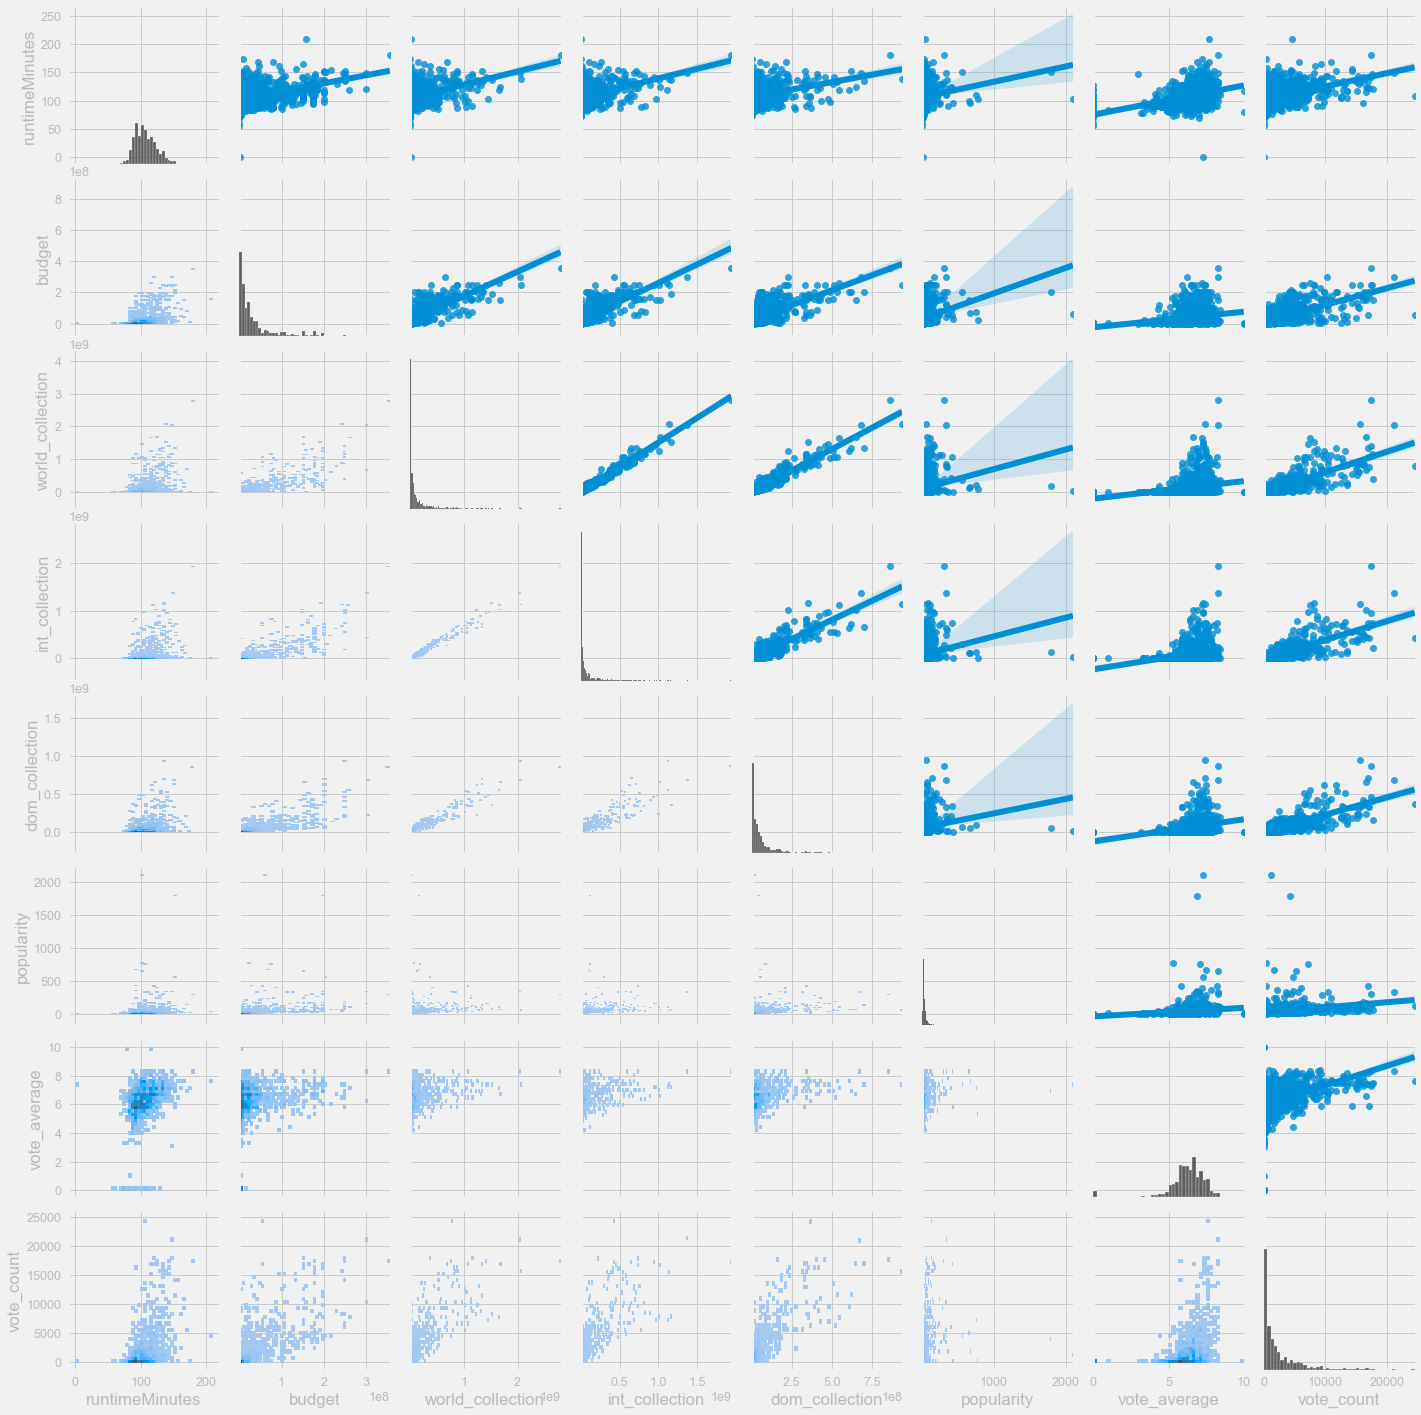

In [101]:
with plt.style.context('fivethirtyeight'):
    g = sns.PairGrid(main_df[list_for_pairplot],layout_pad=.2)
    g.map_diag(sns.histplot)
    g.map_upper(sns.regplot)
    g.map_lower(sns.histplot)

No severe anamoly spotted in the graph which warrants further investigation .

## Feature engineering

### ROI

Here, budget is the estimetor for cost.

<img src=https://www.ispringsolutions.com/blog/wp-content/uploads/editor/2019/06/ispring-blog-image-1559837814.png
     alt="ROI formula"
     style="float: left; margin-right: 10px;" />



#### Return on investment in $ value

In [102]:
main_df['ROI'] = main_df.world_collection - main_df.budget

#### Return on investment in percentage, 
expressed in full, not in decimal

In [103]:
main_df['ROI_percentage'] = (main_df.ROI / main_df.budget)*100

## Final Check to see that everything is in place

In [104]:
main_df.shape

(1113, 20)

In [105]:
main_df.head()

imdb_id         primaryTitle                         originalTitle  \
4   tt0369610       Jurassic World                        Jurassic World   
6   tt0385887  Motherless Brooklyn                   Motherless Brooklyn   
11  tt0437086  Alita: Battle Angel                   Alita: Battle Angel   
12  tt0441881         Danger Close  Danger Close: The Battle of Long Tan   
14  tt0443533  The History of Love                   The History of Love   

    startYear release_date  runtimeMinutes     budget  world_collection  \
4        2015   2015-06-06             124  150000000      1.671713e+09   
6        2019   2019-10-31             144   26000000      1.847774e+07   
11       2019   2019-01-31             122  170000000      4.049805e+08   
12       2019   2019-08-08             118   23934823      2.088085e+06   
14       2016   2016-11-09             134   20000000      4.922720e+05   

    int_collection  dom_collection  popularity  vote_average  vote_count  \
4     1.018131e+09     652385625.0      63.489           6.6       16595   
6     9.200000e+06       9277736.0      75.020           6.8         842   
11    3.191423e+08      85838210.0     175.798           7.2        6343   
12    2.088085e+06             NaN     112.552           6.8         148   
14    4.922720e+05             NaN       5.406           6.4          63   

                                      production_comp original_language  \
4   Amblin Entertainment, Legendary Pictures, Univ...                en   
6                          Class 5 Films, MWM Studios                en   
11  Troublemaker Studios, Lightstorm Entertainment...                en   
12  Red Dune Films, Full Clip Productions, Deeper ...                en   
14  2.4.7. Films, Oï  Oï  Oï Productions, Caramel ...                en   

   belongs_to_collection.name                   genres  release_year  \
4    Jurassic Park Collection  Action,Adventure,Sci-Fi          2015   
6                         NaN      Crime,Drama,Mystery          2019   
11                        NaN  Action,Adventure,Sci-Fi          2019   
12                        NaN         Action,Drama,War          2019   
14                        NaN        Drama,Romance,War          2016   

             ROI  ROI_percentage  
4   1.521713e+09     1014.475472  
6  -7.522264e+06      -28.931785  
11  2.349805e+08      138.223849  
12 -2.184674e+07      -91.275954  
14 -1.950773e+07      -97.538640

In [106]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1113 entries, 4 to 13585
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   imdb_id                     1113 non-null   object        
 1   primaryTitle                1113 non-null   object        
 2   originalTitle               1113 non-null   object        
 3   startYear                   1113 non-null   int64         
 4   release_date                1113 non-null   datetime64[ns]
 5   runtimeMinutes              1113 non-null   int64         
 6   budget                      1113 non-null   int64         
 7   world_collection            1113 non-null   float64       
 8   int_collection              1039 non-null   float64       
 9   dom_collection              882 non-null    float64       
 10  popularity                  1113 non-null   float64       
 11  vote_average                1113 non-null   float64    

In [107]:
main_df.describe()

startYear  runtimeMinutes        budget  world_collection  \
count  1113.000000     1113.000000  1.113000e+03      1.113000e+03   
mean   2016.993711      107.323450  3.841841e+07      1.271450e+08   
std       1.532899       17.613393  5.251428e+07      2.613752e+08   
min    2014.000000        0.000000  5.000000e+03      5.470000e+02   
25%    2016.000000       94.000000  6.000000e+06      2.084628e+06   
50%    2017.000000      105.000000  1.900000e+07      2.935520e+07   
75%    2018.000000      118.000000  4.000000e+07      1.195200e+08   
max    2020.000000      209.000000  3.560000e+08      2.797801e+09   

       int_collection  dom_collection   popularity  vote_average  \
count    1.039000e+03    8.820000e+02  1113.000000   1113.000000   
mean     8.259442e+07    6.207522e+07    43.486649      6.261995   
std      1.761494e+08    1.039024e+08   103.773946      1.246853   
min      5.470000e+02    1.377000e+03     0.600000      0.000000   
25%      1.177836e+06    5.622565e+06    13.550000      5.800000   
50%      1.424425e+07    2.740507e+07    22.168000      6.400000   
75%      6.891399e+07    6.725403e+07    41.249000      7.000000   
max      1.939128e+09    9.366622e+08  2103.518000     10.000000   

         vote_count  release_year           ROI  ROI_percentage  
count   1113.000000   1113.000000  1.113000e+03     1113.000000  
mean    2338.715184   2017.052111  8.872658e+07      296.570055  
std     3332.521354      1.522309  2.226630e+08     1647.220419  
min        0.000000   2015.000000 -1.510000e+08      -99.981875  
25%      266.000000   2016.000000 -3.898454e+06      -69.544079  
50%     1020.000000   2017.000000  8.197072e+06       63.263233  
75%     3038.000000   2018.000000  7.501105e+07      296.521358  
max    24543.000000   2020.000000  2.441801e+09    42864.410000

>if only want to focus on profitable movies

In [108]:
# main_df = main_df[main_df.ROI>0]

# Exploratory data analysis

## EDA - top movie by return %

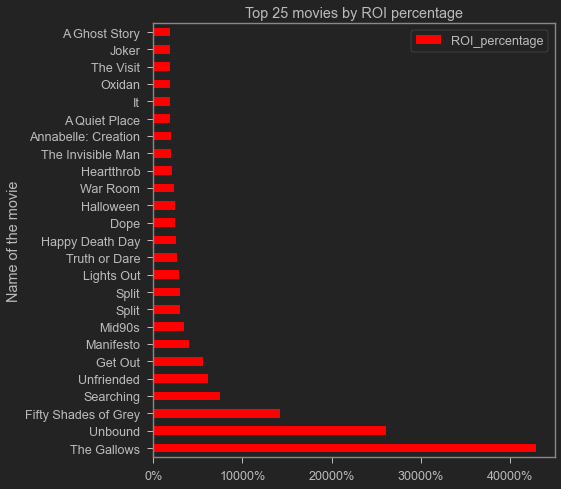

In [109]:
ax = main_df.sort_values(by='ROI_percentage',
                         ascending=False).head(25).plot(kind='barh',
                                                        x='primaryTitle',
                                                        y='ROI_percentage',
                                                        color="red")
plt.title('Top 25 movies by ROI percentage')
plt.ylabel('Name of the movie')
plt.tight_layout()
ax.xaxis.set_major_formatter(format_add_percentage)
plt.show()

## EDA - top movie by gross profit

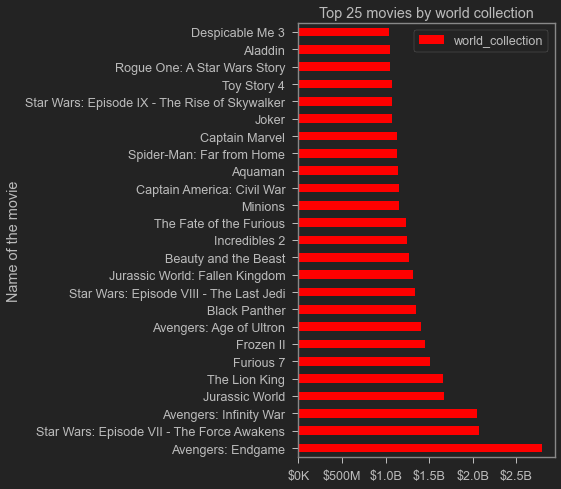

In [110]:
ax = main_df.sort_values(by='world_collection',
                         ascending=False).head(25).plot(kind='barh',
                                                        x='primaryTitle',
                                                        y='world_collection',
                                                        color="red")
plt.title('Top 25 movies by world collection')
plt.ylabel('Name of the movie')
ax.xaxis.set_major_formatter(format_number)
plt.tight_layout()
plt.show()

## EDA - profit by top 20 studio

>For competitor analysis and assessing market condition

In [111]:
studio_df = main_df.copy()

In [112]:
studio_df.loc[:, 'production_comp_exp'] = studio_df.production_comp.map(
    lambda x: x.split(', '))

In [113]:
studio_df_fig = studio_df.explode('production_comp_exp')

In [114]:
studio_df_fig.head(3)

imdb_id    primaryTitle   originalTitle  startYear release_date  \
4  tt0369610  Jurassic World  Jurassic World       2015   2015-06-06   
4  tt0369610  Jurassic World  Jurassic World       2015   2015-06-06   
4  tt0369610  Jurassic World  Jurassic World       2015   2015-06-06   

   runtimeMinutes     budget  world_collection  int_collection  \
4             124  150000000      1.671713e+09    1.018131e+09   
4             124  150000000      1.671713e+09    1.018131e+09   
4             124  150000000      1.671713e+09    1.018131e+09   

   dom_collection  popularity  vote_average  vote_count  \
4     652385625.0      63.489           6.6       16595   
4     652385625.0      63.489           6.6       16595   
4     652385625.0      63.489           6.6       16595   

                                     production_comp original_language  \
4  Amblin Entertainment, Legendary Pictures, Univ...                en   
4  Amblin Entertainment, Legendary Pictures, Univ...                en   
4  Amblin Entertainment, Legendary Pictures, Univ...                en   

  belongs_to_collection.name                   genres  release_year  \
4   Jurassic Park Collection  Action,Adventure,Sci-Fi          2015   
4   Jurassic Park Collection  Action,Adventure,Sci-Fi          2015   
4   Jurassic Park Collection  Action,Adventure,Sci-Fi          2015   

            ROI  ROI_percentage   production_comp_exp  
4  1.521713e+09     1014.475472  Amblin Entertainment  
4  1.521713e+09     1014.475472    Legendary Pictures  
4  1.521713e+09     1014.475472    Universal Pictures

In [115]:
top_production_house_list = list(
    studio_df_fig.production_comp_exp.value_counts().sort_values(
        ascending=False)[:20].index)

In [116]:
# to get Total worldwide $ collection by top 20 studios over the years
studio_df_fig_0 = studio_df_fig[studio_df_fig['production_comp_exp'].isin(
    top_production_house_list)]

In [117]:
# Total worldwide $ collection by top 20 studios
studio_df_fig_1 = studio_df_fig.groupby(
    by='production_comp_exp').agg('sum').sort_values(by='world_collection',
                                                     ascending=False)[:20]
# Total releases by top 20 studios
studio_df_fig_2 = studio_df_fig.groupby(
    by='production_comp_exp').agg('count').sort_values(by='world_collection',
                                                       ascending=False)[:20]

In [118]:
# Collection Performance of top 10 movie studios
studio_df_fig_merged = pd.merge(
    studio_df_fig.groupby(by='production_comp_exp').agg('sum').sort_values(
        by='world_collection',
        ascending=False)['world_collection'].reset_index(),
    studio_df_fig.groupby(by='production_comp_exp').agg('count').sort_values(
        by='world_collection',
        ascending=False)['world_collection'].reset_index(),
    on='production_comp_exp')
# Budget Performance of top 10 movie studios
studio_df_fig_merged_1 = pd.merge(
    studio_df_fig.groupby(by='production_comp_exp').agg('sum').sort_values(
        by='budget',
        ascending=False)['budget'].reset_index(),
    studio_df_fig.groupby(by='production_comp_exp').agg('count').sort_values(
        by='budget',
        ascending=False)['budget'].reset_index(),
    on='production_comp_exp')

In [119]:
## from https://plotly.com/python/multiple-axes/ ##official plotly how to instructions
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig.add_trace(
    go.Bar(x=studio_df_fig_merged.production_comp_exp[:10],
           y=studio_df_fig_merged.world_collection_x[:10],
           name="World Collection",
           offset=True),
    secondary_y=False,
)
fig.add_trace(
    go.Bar(x=studio_df_fig_merged.production_comp_exp[:10],
           y=studio_df_fig_merged.world_collection_y[:10],
           name="Movie Released",
           offset=True,
           opacity=.6),
    secondary_y=True,
)
# Add figure title
fig.update_layout(title_text="Collection performance of top 10 movie studios")
# Set x-axis title
fig.update_xaxes(title_text="World Collection")
# Set y-axes titles
fig.update_yaxes(title_text="<b>World Collection</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Number of Movie Released</b>",
                 secondary_y=True)
fig.show()

In [120]:
## from https://plotly.com/python/multiple-axes/ ##official plotly how to instructions
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig.add_trace(
    go.Bar(x=studio_df_fig_merged_1.production_comp_exp[:10],
           y=studio_df_fig_merged_1.budget_x[:10],
           name="Budget",
           offset=True),
    secondary_y=False,
)
fig.add_trace(
    go.Bar(x=studio_df_fig_merged_1.production_comp_exp[:10],
           y=studio_df_fig_merged_1.budget_y[:10],
           name="Movie Released",
           offset=True,
           opacity=.6),
    secondary_y=True,
)
# Add figure title
fig.update_layout(title_text="Budget performance of top 10 movie studios")
# Set x-axis title
fig.update_xaxes(title_text="Budget")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Budget</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Number of Movie Released</b>",
                 secondary_y=True)
fig.show()

Marvel Studios and Walt Disney has the best release count to world collection ratio. It took Universal Pictures way more budget to achieve the top spot.

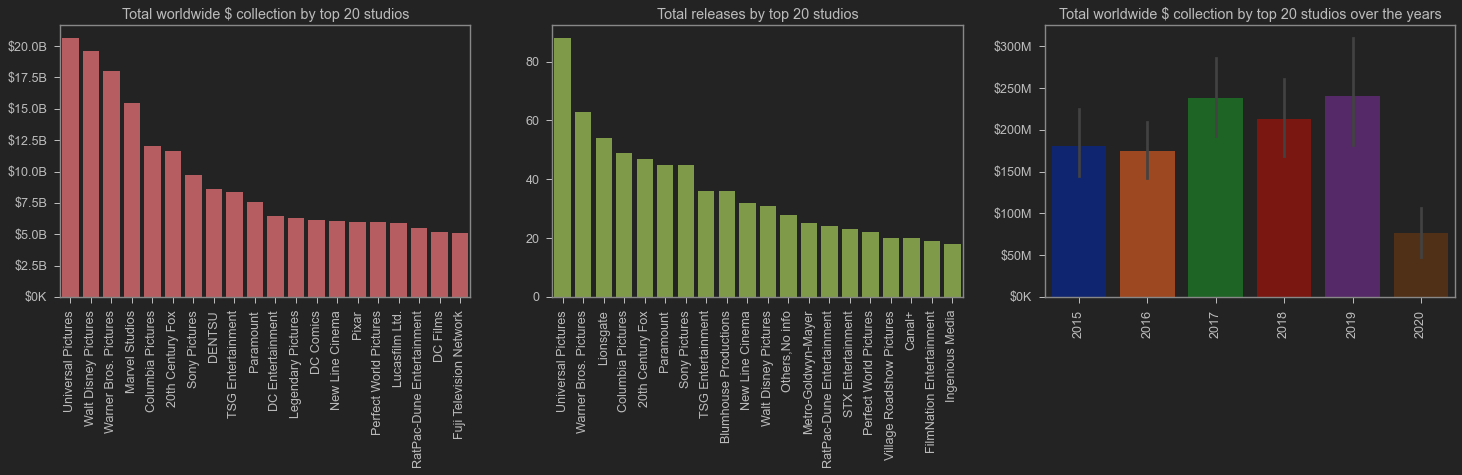

In [121]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 3, 1)
plt.xticks(rotation='vertical')

plt.title('Total worldwide $ collection by top 20 studios')

sns.barplot(y='world_collection',
            x='production_comp_exp',
            data=studio_df_fig_1.reset_index(),
            color='r').yaxis.set_major_formatter(
                format_number) 
plt.xlabel(None)
plt.ylabel(None)


plt.subplot(1, 3, 2)
sns.barplot(y='world_collection',
            x='production_comp_exp',
            data=studio_df_fig_2.reset_index(),
            color='g').set(xlabel=None, ylabel=None)

plt.xticks(rotation='vertical')

plt.title('Total releases by top 20 studios')

plt.subplot(1, 3, 3)
sns.barplot(data=studio_df_fig_0,
            x='release_year',
            y='world_collection',
            palette='dark').yaxis.set_major_formatter(
                format_number)
plt.title('Total worldwide $ collection by top 20 studios over the years')
plt.xticks(rotation='vertical')
plt.xlabel(None)
plt.ylabel(None)
# plt.tight_layout()
plt.show()

One caveat of this graph is that because of the nature of the data, if a movie has multiple studios attached to it then all earnings of it is counted as the studios sole earnings. This is the reason why the mismatch of metrics. All things set aside, from this graph a visual understanding can be achieved about top studios without trying to make sense of the numbers. Turning off ylabels of first two plots can help on that regard. 

## EDA - Relation between features

In [122]:
corelattion_filter_list = ['startYear',
       'runtimeMinutes', 'budget', 'world_collection', 'int_collection',
       'dom_collection', 'popularity', 'vote_average', 'vote_count']

In [123]:
corr_df = main_df[corelattion_filter_list]

In [124]:
corr_df_matrix = corr_df.corr()

In [125]:
corr_df_matrix.style.background_gradient()

In [126]:
correlation_top_bottom(corr_df_matrix)

Positive correlations:
          index                        feature_combo  correlation
0     31  world_collection and int_collection     0.986302
1     32  dom_collection and world_collection     0.955519
2     41    dom_collection and int_collection     0.892850
3     35      world_collection and vote_count     0.791444
4     22            budget and int_collection     0.787109
5     21          budget and world_collection     0.783042
6     53        dom_collection and vote_count     0.773461
7     44        vote_count and int_collection     0.763741
8     23            budget and dom_collection     0.716023
9     47            dom_collection and budget     0.716023

 ----------------------------------------------------------------------
       Negative correlations:
          index                   feature_combo  correlation
0      8        startYear and vote_count    -0.065041
1      1    startYear and runtimeMinutes    -0.003422
2      3  startYear and world_collection     0.02

### Findings and observation

From those table it can be observed that world collection, international collection and domestic collection is highly correlated. It is expected as world collection is a dependent variable of the other two. And the later two are highly correlated. This is also expected, as this is indicator of a profitable versus flop movie. Better performing movies has higher popularity as explained by world collection versus vote count, vice versa. High budget movies perform better overseas.

Overall budget is the key for indicating performance both in international and domestic performance and feedback from movie consumers. No other standout correlation was found. 

# Recommendations

## Which genre of movie to make, explained by top movie per genre 

In [127]:
genere_df = main_df.copy()

In [128]:
genere_df.loc[:,'genres_exp'] = genere_df.genres.map(lambda x: x.split(','))

In [129]:
genere_df_fig = genere_df.explode('genres_exp')

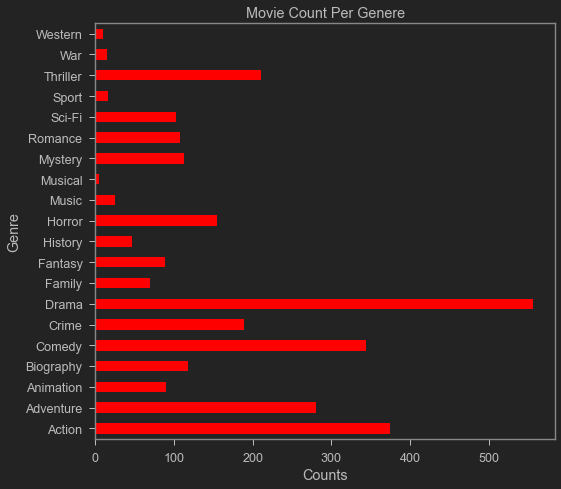

In [130]:
# Movie Count Per Genere
genere_df_fig.groupby('genres_exp').count()['imdb_id'].plot(kind='barh',
                                                            color="red")
plt.title('Movie Count Per Genere')
plt.ylabel('Genre')
plt.xlabel('Counts')
plt.tight_layout()
plt.show()

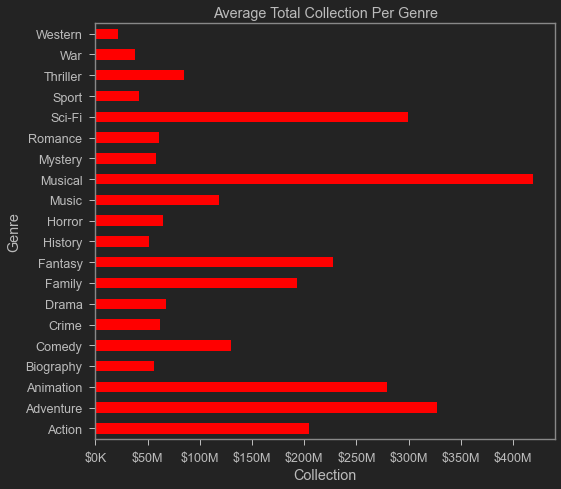

In [131]:
# Average Total Collection Per Genere
genere_df_fig.groupby('genres_exp').mean()['world_collection'].plot(
    kind='barh',color="red").xaxis.set_major_formatter(format_number)
plt.title('Average Total Collection Per Genre')
plt.ylabel('Genre')
plt.xlabel('Collection')           
plt.tight_layout()
plt.show()

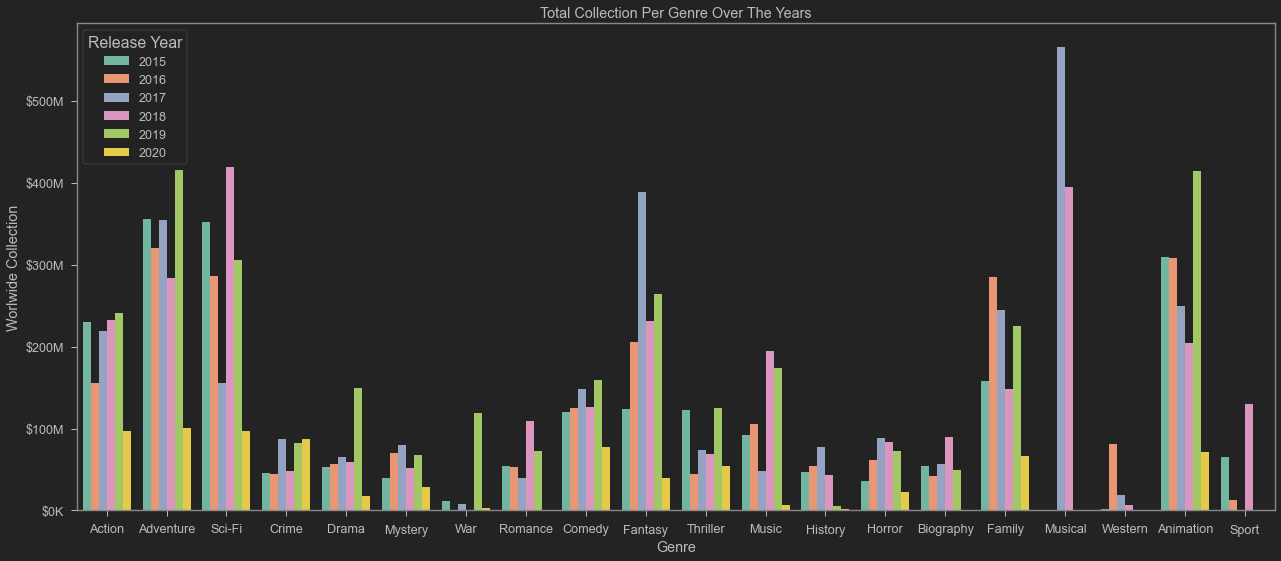

In [132]:
# styling
# sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
# plotting
sns.barplot(data=genere_df_fig,
            x='genres_exp',
            y='world_collection',
            hue='release_year',
            palette='Set2',
            ci=None).yaxis.set_major_formatter(format_number)
plt.title('Total Collection Per Genre Over The Years')
plt.ylabel('Worlwide Collection')
plt.xlabel('Genre')
plt.legend(title='Release Year', title_fontsize='large')
plt.tight_layout()
plt.show()

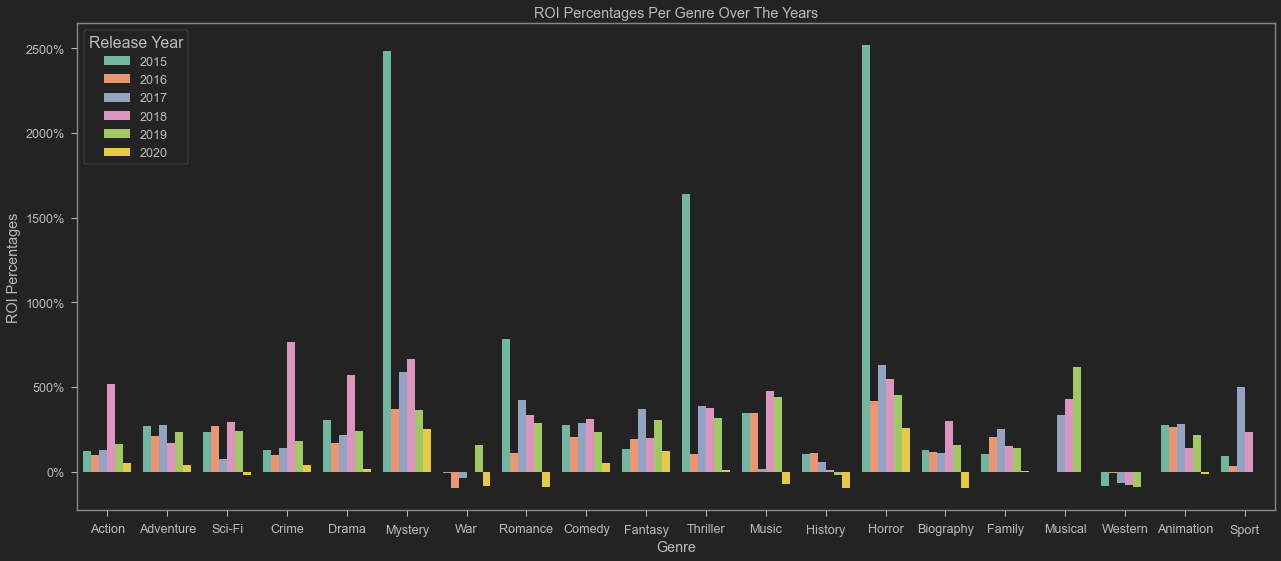

In [133]:
# styling
# sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
# plotting
sns.barplot(data=genere_df_fig,
            x='genres_exp',
            y='ROI_percentage',
            hue='release_year', palette='Set2',ci=None).yaxis.set_major_formatter(format_add_percentage)
plt.title('ROI Percentages Per Genre Over The Years')
plt.ylabel('ROI Percentages')
plt.xlabel('Genre')           
plt.legend(title='Release Year', title_fontsize= 'large')
plt.tight_layout()
plt.show()

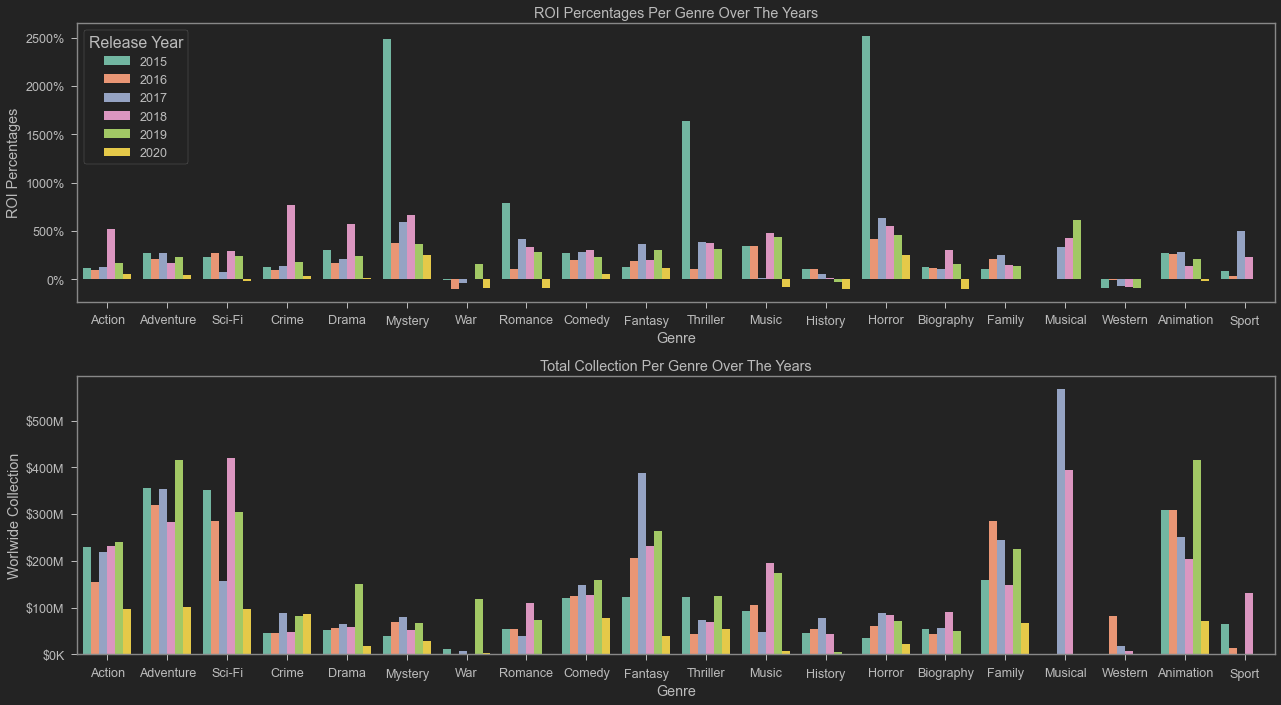

In [134]:
plt.figure(figsize=(18, 10))
# plotting
plt.subplot(2, 1, 1)
sns.barplot(data=genere_df_fig,
            x='genres_exp',
            y='ROI_percentage',
            hue='release_year',
            palette='Set2',
            ci=None).yaxis.set_major_formatter(format_add_percentage)
plt.title('ROI Percentages Per Genre Over The Years')
plt.ylabel('ROI Percentages')
plt.xlabel('Genre')
plt.legend(title='Release Year', title_fontsize='large')
plt.tight_layout()

plt.subplot(2, 1, 2)
sns.barplot(data=genere_df_fig,
            x='genres_exp',
            y='world_collection',
            hue='release_year',
            palette='Set2',
            ci=None).yaxis.set_major_formatter(format_number)
plt.title('Total Collection Per Genre Over The Years')
plt.ylabel('Worlwide Collection')
plt.xlabel('Genre')
plt.legend().remove()
plt.tight_layout()

plt.show()

2015 was a good year for the industry. Animation has good performance but costly to make, hence lower percentage. Muscial had few good years then fell out of fashion. Action, Adventure, Family, Fantasy has been consistent performers. Horror and Mystery has high return percentage.

### Action suggestion

Any one or combination of Action, Adventure, Animation is recommended. Animation and Action has 35% chance for occurring as genre combo. There is no landslide winner here, although this graphs can be used to figure out which one to avoid, for example western and war. 

## Best time to release movie

In [135]:
timing_df = main_df.copy()

In [136]:
timing_df['release_month']=timing_df['release_date'].dt.month

- minor feature engineering

Release months are put in three bins based on market analysts opinion.The [dump months](https://en.wikipedia.org/wiki/Dump_months) are what the film community calls the two periods of the year when there are lowered commercial and critical expectations for most new releases from American filmmakers and distributors.

1. January - May: Dump month
3. June - July: Summer
3. August - October: Dump month
4. November - December: Holidays




In [137]:
timing_df['release_timing'] = pd.cut(
    timing_df['release_month'],
    bins=[0, 6, 8, 10, 12],
    labels=['dump months', 'summer', 'dump months', 'holidays'],
    ordered=False)

In [138]:
timing_df.head(3)

imdb_id         primaryTitle        originalTitle  startYear  \
4   tt0369610       Jurassic World       Jurassic World       2015   
6   tt0385887  Motherless Brooklyn  Motherless Brooklyn       2019   
11  tt0437086  Alita: Battle Angel  Alita: Battle Angel       2019   

   release_date  runtimeMinutes     budget  world_collection  int_collection  \
4    2015-06-06             124  150000000      1.671713e+09    1.018131e+09   
6    2019-10-31             144   26000000      1.847774e+07    9.200000e+06   
11   2019-01-31             122  170000000      4.049805e+08    3.191423e+08   

    dom_collection  popularity  vote_average  vote_count  \
4      652385625.0      63.489           6.6       16595   
6        9277736.0      75.020           6.8         842   
11      85838210.0     175.798           7.2        6343   

                                      production_comp original_language  \
4   Amblin Entertainment, Legendary Pictures, Univ...                en   
6                          Class 5 Films, MWM Studios                en   
11  Troublemaker Studios, Lightstorm Entertainment...                en   

   belongs_to_collection.name                   genres  release_year  \
4    Jurassic Park Collection  Action,Adventure,Sci-Fi          2015   
6                         NaN      Crime,Drama,Mystery          2019   
11                        NaN  Action,Adventure,Sci-Fi          2019   

             ROI  ROI_percentage  release_month release_timing  
4   1.521713e+09     1014.475472              6    dump months  
6  -7.522264e+06      -28.931785             10    dump months  
11  2.349805e+08      138.223849              1    dump months

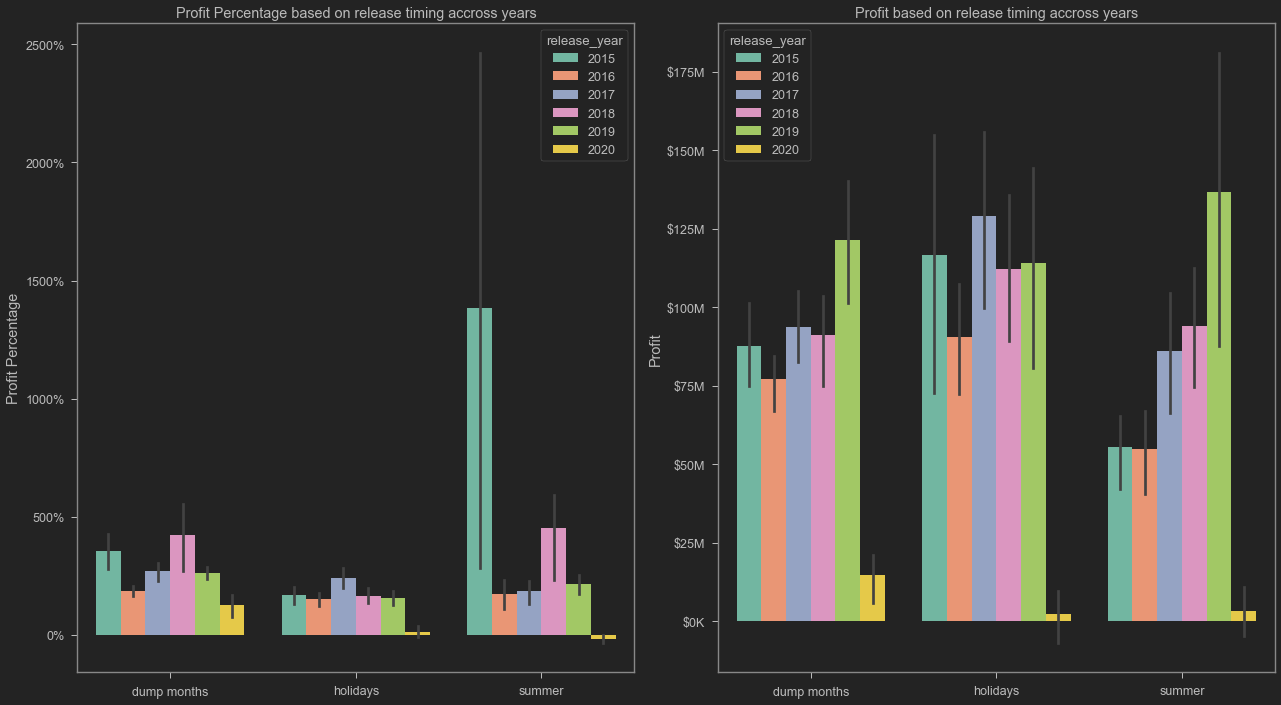

In [139]:
plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
sns.barplot(data=timing_df,
            x='release_timing',
            y='ROI_percentage',
            hue='release_year',palette='Set2',
            ci=50).yaxis.set_major_formatter(format_add_percentage)
plt.title('Profit Percentage based on release timing accross years')
plt.ylabel('Profit Percentage')
plt.xlabel("")

plt.subplot(1, 2, 2)
sns.barplot(data=timing_df,
            x='release_timing',
            y='ROI',
            hue='release_year',palette='Set2',
            ci=50).yaxis.set_major_formatter(format_number)
plt.title('Profit based on release timing accross years')
plt.ylabel('Profit')
plt.xlabel("")
plt.tight_layout()

plt.show()

2015's Summer was good in terms of percentage return but weirdly did not generate much cash. Releasing movie in the holidays season is the safest bet. But summer is having a consistent raise, except for 2020. 2020's summer was not normal by any means, thus this is expected. 

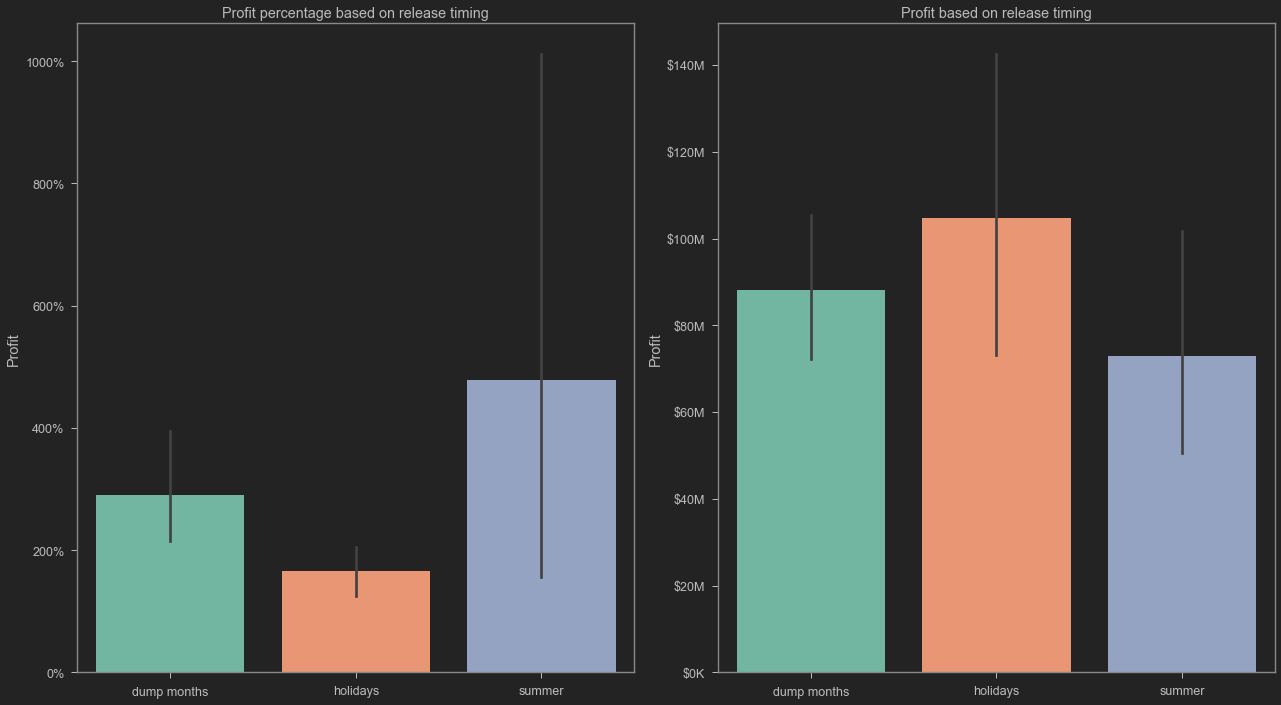

In [140]:
plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 2)
sns.barplot(data=timing_df, x='release_timing', y='ROI',
            palette='Set2').yaxis.set_major_formatter(format_number)
plt.title('Profit based on release timing')
plt.ylabel('Profit')
plt.xlabel("")
plt.tight_layout()

plt.subplot(1, 2, 1)
sns.barplot(data=timing_df,
            x='release_timing',
            y='ROI_percentage',
            palette='Set2').yaxis.set_major_formatter(format_add_percentage)
plt.title('Profit percentage based on release timing')
plt.ylabel('Profit')
plt.xlabel("")
plt.tight_layout()

plt.show()

Movies released in holidays earn consistent returns but costs more. Summer is more dollar generating and volatile in a good way, on a uptrend.

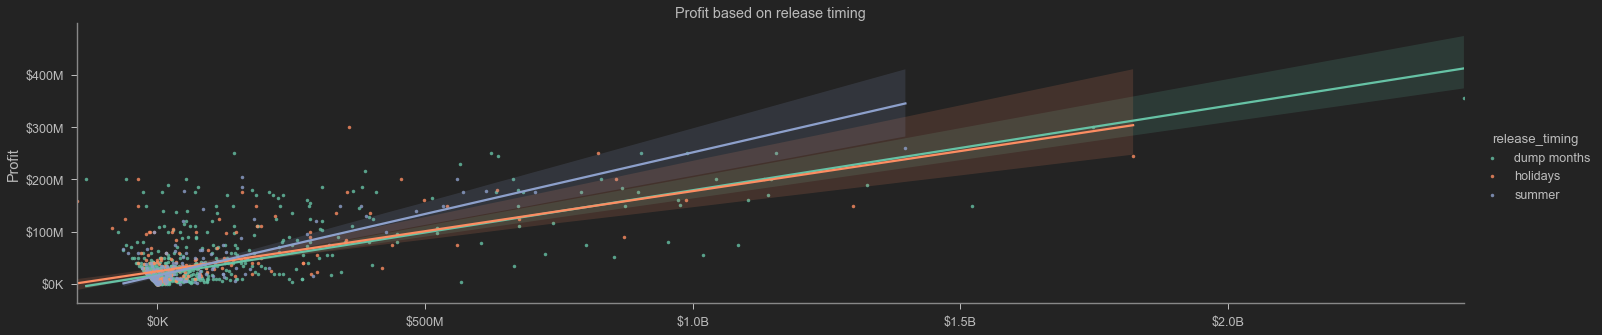

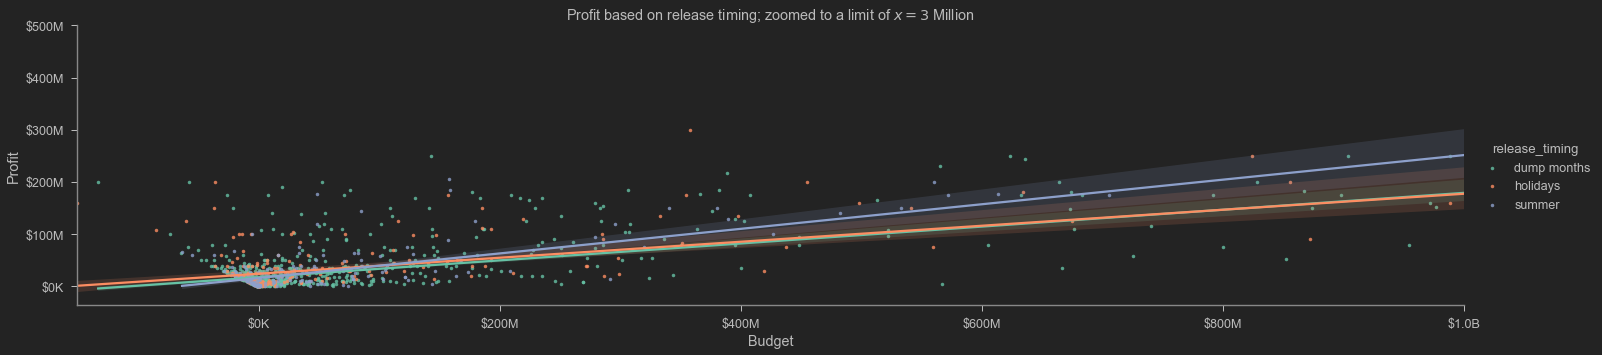

In [141]:
# Profit based on release timing
g = sns.lmplot(data=timing_df,
               x='ROI',
               y='budget',
               hue='release_timing',
               fit_reg=True,
               markers='.',
               aspect=4,palette='Set2',
               robust=True)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(format_number)
    ax.xaxis.set_major_formatter(format_number)
plt.title('Profit based on release timing')
plt.ylabel('Profit')
plt.xlabel("")

g = sns.lmplot(data=timing_df,
               x='ROI',
               y='budget',
               hue='release_timing',
               fit_reg=True,
               markers='.',
               aspect=4,palette='Set2',
               robust=True)
plt.xlim(right=1000000000)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(format_number)
    ax.xaxis.set_major_formatter(format_number)
plt.title('Profit based on release timing; zoomed to a limit of $x=3$ Million')
plt.ylabel('Profit')
plt.xlabel("Budget")

plt.show()

Text(0.5, 0.98, 'Relationship between budget and ROI based on release timing')

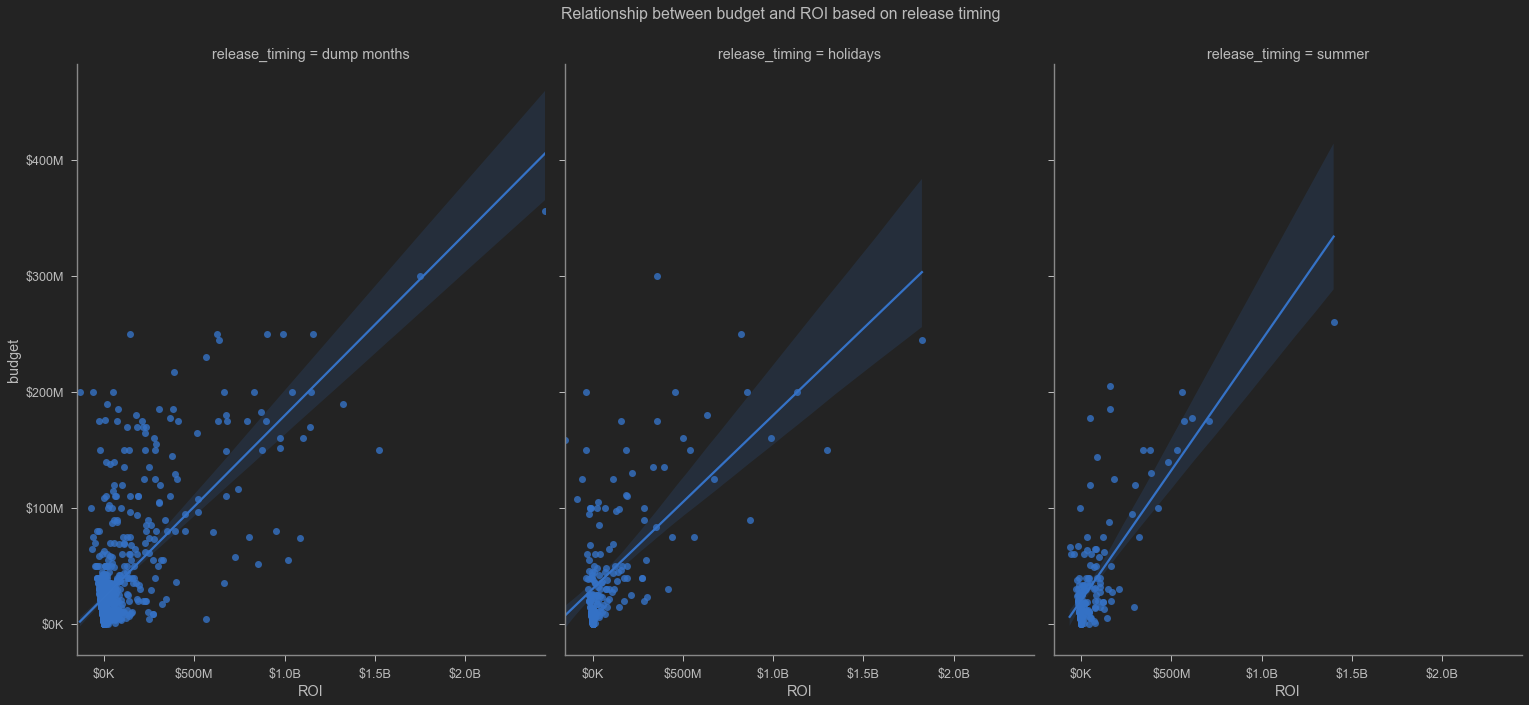

In [142]:
# Relationship between budget and ROI based on release timing
g = sns.FacetGrid(
   timing_df, col='release_timing', 
   height=10, aspect=.7, palette='Set2')
g.map(sns.regplot, 'ROI', 'budget')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(format_number)
    ax.xaxis.set_major_formatter(format_number)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Relationship between budget and ROI based on release timing')

Producing movies for summer release is more costly, but return is steeper. Number of movies beyond 500 million is more frequent as well as observation counts are higher for holidays release, and the line is flatter meaning less costly to produce. Holidays season is the better option.

Text(0.5, 0.98, 'Relationship between budget and ROI percentage based on release timing')

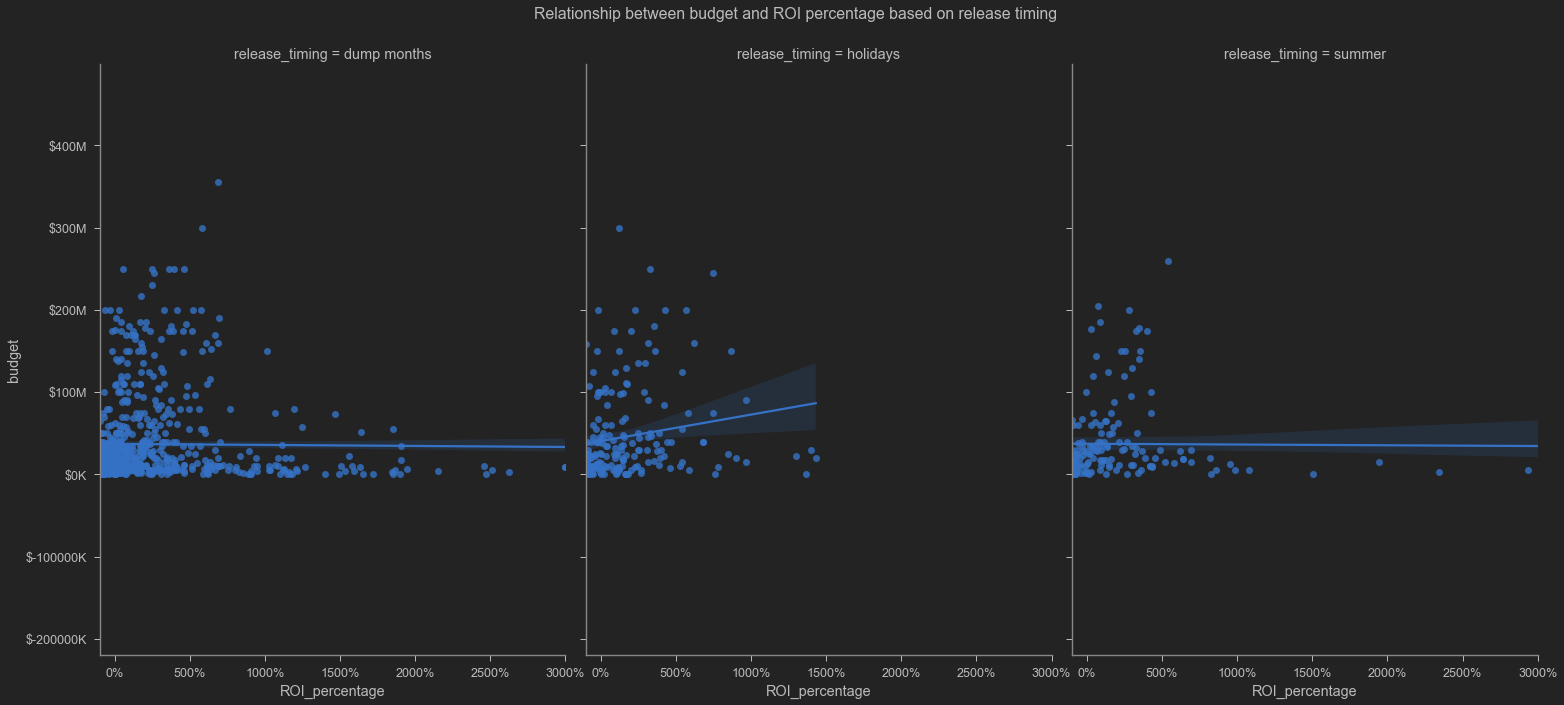

In [143]:
# Relationship between budget and ROI based on release timing
g = sns.FacetGrid(
   timing_df, col='release_timing', 
   height=10, aspect=.7, palette='Set2')
g.map(sns.regplot, 'ROI_percentage', 'budget')
plt.xlim(right=3000)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(format_number)
    ax.xaxis.set_major_formatter(format_add_percentage)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Relationship between budget and ROI percentage based on release timing')

summer has the best earning potential. But line is steeper for holidays, confirming the point made on the previous graph.

Text(0.5, 0, 'Average user vote')

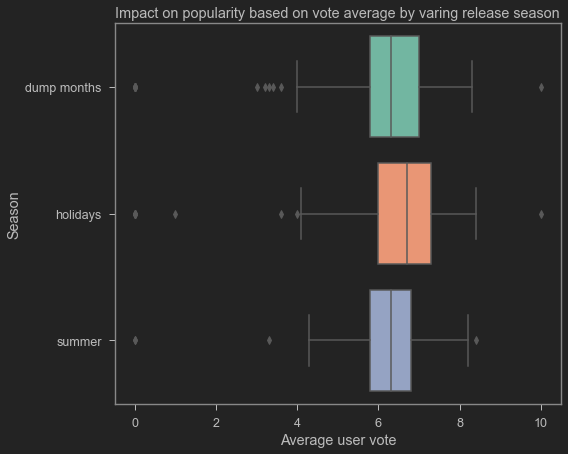

In [144]:
# impact on popularity based on vote average by varing release season
sns.boxplot(x='vote_average', y='release_timing',data=timing_df, palette='Set2')
plt.title('Impact on popularity based on vote average by varing release season')
plt.ylabel('Season')
plt.xlabel("Average user vote")

Holidays movies are more popular and catch people on good mood maybe? Or content is less experimental. Reasoning can not be drawn from this figure but it can be said that holidays movies are more popular, which is good for entering the market with a more favorable impression on people.

### Action suggestion

My recommendation is to focus for release schedule in the holidays season. There is higher probability of financial and critical success for movies released in that time frame. It is relatively cheaper to make than the next best option; i.e., Summer.

## Franchise performance analysis leading to recommendation 

In [145]:
# getting a copy of main_df
franchaise_df_main = main_df.copy()

In [146]:
# getting all movies that are part of a franchaise
franchaise_df = franchaise_df_main[~main_df['belongs_to_collection.name'].isna(
)]

In [147]:
# renameing column for use later
franchaise_df = franchaise_df.rename(
    columns={"belongs_to_collection.name": "belongs_to_collection"})

In [148]:
# getting all movies that are not part of a franchaise, yet!
non_franchaise_df = franchaise_df_main[
    main_df['belongs_to_collection.name'].isna()].copy()

### Franchise info 

By franchise I mean serialization of movies either based on a related intellectual property or sharing same cinematic universe.

In [149]:
# list of unique franchaise names
list_of_franchaise = franchaise_df['belongs_to_collection'].unique()

In [150]:
franchaise_df_ = franchaise_df.groupby('belongs_to_collection').mean(
).ROI_percentage.sort_values(ascending=False).reset_index()

In [151]:
# formatting
format_dict = {
    'ROI': '${0:,.0f}',
    'budget': '${0:,.0f}',
    'ROI_percentage': '{:.2f}%'
}
# performance of movies that are part of a franchaise
franchaise_df.groupby('belongs_to_collection').mean()[[
    'ROI_percentage', 'ROI', 'budget'
]].sort_values(
    by='ROI_percentage',
    ascending=False)[:20].style.format(format_dict).background_gradient(
        cmap='afmhot')

Most franchise earn a lot on their investment. This is expected as there is a reason for film makers to visit same universe several times. More often than not it is because of their proven success record and popularity among movie consumers.

#### which genre to franchaise

In [152]:
print('On an average films that are part of a franchaise earn {:.2f}% return.'.
      format(franchaise_df.ROI_percentage.mean()))

On an average films that are part of a franchaise earn 727.47% return.


In [153]:
# joining and filtering using SQL statements
list_of_franchaise_df0 = sqldf("""SELECT 
            DISTINCT belongs_to_collection, 
            a.ROI AS 'ROI', b.world_collection, 
            b.genres 
        FROM franchaise_df AS a 
        JOIN franchaise_df AS b 
        USING(belongs_to_collection);""")

format_dict = {'ROI': '${0:,.0f}', 'world_collection': '${0:,.0f}'}

list_of_franchaise_df0[~list_of_franchaise_df0.belongs_to_collection.
                       duplicated()].sort_values(
                           by='ROI',
                           ascending=False)[:15].style.background_gradient(
                               cmap='bwr').hide_index().format(format_dict)

Observation: None of them fall into a single genre.

In [154]:
# joining and filtering using SQL statements
list_of_franchaise_df = sqldf(
    """SELECT 
            belongs_to_collection, 
            a.ROI_percentage AS 'ROI%', 
            b.genres 
        FROM franchaise_df_ AS a 
        JOIN franchaise_df AS b 
        USING(belongs_to_collection);""")

In [155]:
# most often produced genre for serialization of movies 
list_of_franchaise_df.loc[:, 'genres_exp'] = list_of_franchaise_df.genres.map(
    lambda x: x.split(','))

franchaise_genre = list_of_franchaise_df.explode('genres_exp').groupby(
    'genres_exp').agg(['count', 'mean']).sort_values(by=('ROI%', 'count'),
                                                     ascending=False)
franchaise_genre.columns = [
    " ".join(pair) for pair in franchaise_genre.columns
]
franchaise_genre=franchaise_genre.reset_index()
franchaise_genre.style.background_gradient(cmap='PRGn')

In [156]:
## from https://plotly.com/python/multiple-axes/ ##official plotly how to instructions
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig.add_trace(
    go.Bar(x=franchaise_genre['genres_exp'],
           y=franchaise_genre['ROI% count'],
           name="Movies released",
           offset=True),
    secondary_y=False,
)
fig.add_trace(
    go.Bar(x=franchaise_genre['genres_exp'],
           y=franchaise_genre['ROI% mean'],
           name="ROI% mean",
           offset=True,
           opacity=.6),
    secondary_y=True,
)
# Add figure title
fig.update_layout(title_text="Most often produced genre for serialized movies ")
# Set x-axis title
fig.update_xaxes(title_text="Genre")
# Set y-axes titles
fig.update_yaxes(title_text="<b>ROI% mean</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Number of Movie Released</b>",
                 secondary_y=True)
fig.show()

Adventure, Action, Comedy market is saturated. Horror, Thriller, Mystery release count is higher with higher mean return percentage. This recommendation will alter if we look at collection instead of ROI% because those genre requires less budget, so the return percentage is generally higher. 

### non franchise info

In [157]:
print(
    'On an average films that are not part of a franchaise earn {:.2f}% return.'
    .format(non_franchaise_df.ROI_percentage.mean()))

On an average films that are not part of a franchaise earn 186.17% return.


In [158]:
non_franchaise_df.loc[:, 'genres_exp'] = non_franchaise_df.genres.map(
    lambda x: x.split(','))

In [159]:
non_franchaise_df = non_franchaise_df.explode('genres_exp')

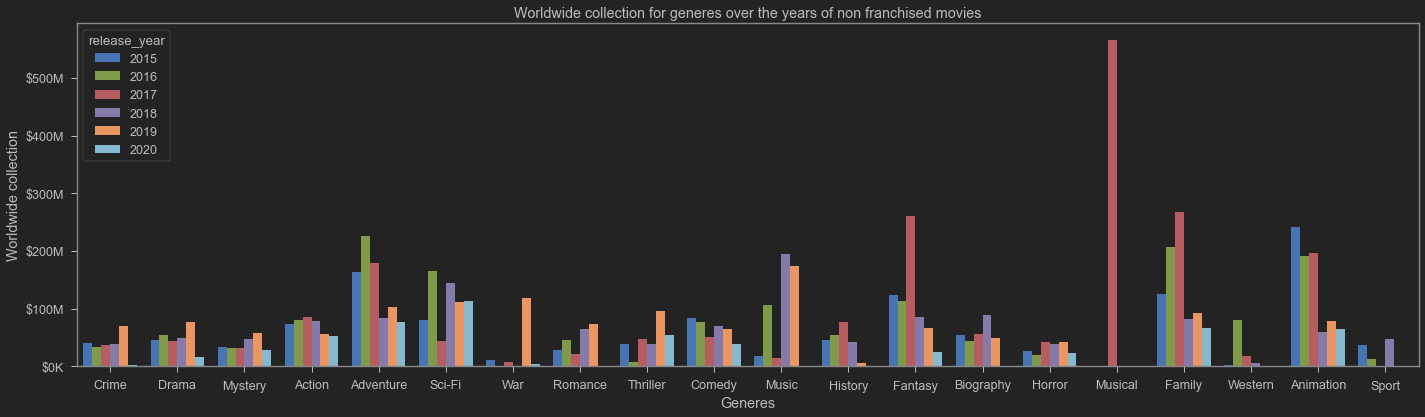

In [160]:
# Worldwide collection for generes over the years of non franchised movies
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
# plotting
sns.barplot(data=non_franchaise_df,
            x='genres_exp',
            y='world_collection',
            hue='release_year',ci=None).yaxis.set_major_formatter(format_number)
plt.title('Worldwide collection for generes over the years of non franchised movies')
plt.ylabel('Worldwide collection')
plt.xlabel("Generes")
plt.tight_layout()

plt.show()

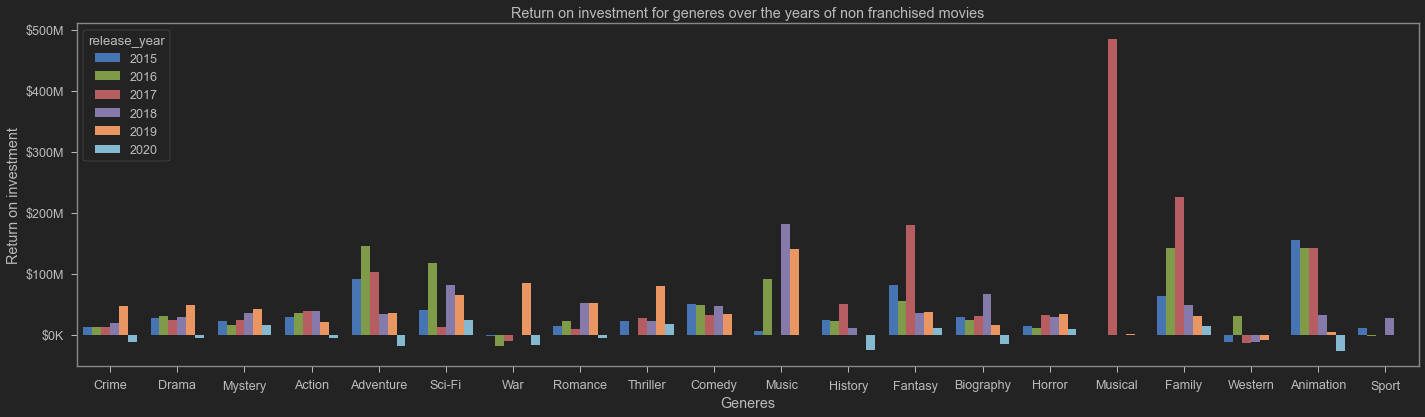

In [161]:
# Return on investment for generes over the years of non franchised movies
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
# plotting
sns.barplot(data=non_franchaise_df,
            x='genres_exp',
            y='ROI',
            hue='release_year',ci=None).yaxis.set_major_formatter(format_number)
plt.title('Return on investment for generes over the years of non franchised movies')
plt.ylabel('Return on investment')
plt.xlabel("Generes")
plt.tight_layout()

plt.show()

Non franchised movies are experiencing a hard time in the box office. The general trend is downwards across the board except Crime and Drama and Mystery. Mystery, Sci-Fi and Horror did well in 2020. Those three genres have high correlation.

### Side by side comparison

Converting franchaise info in to a boolean arrey

In [162]:
franchaise_df_main.loc[~main_df['belongs_to_collection.name'].isna(),
                       'franchaise'] = True

In [163]:
franchaise_df_main.loc[main_df['belongs_to_collection.name'].isna(),
                       'franchaise'] = False

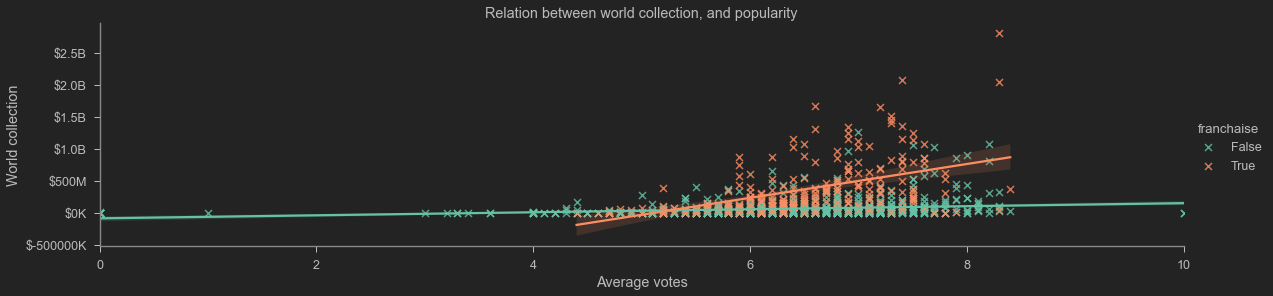

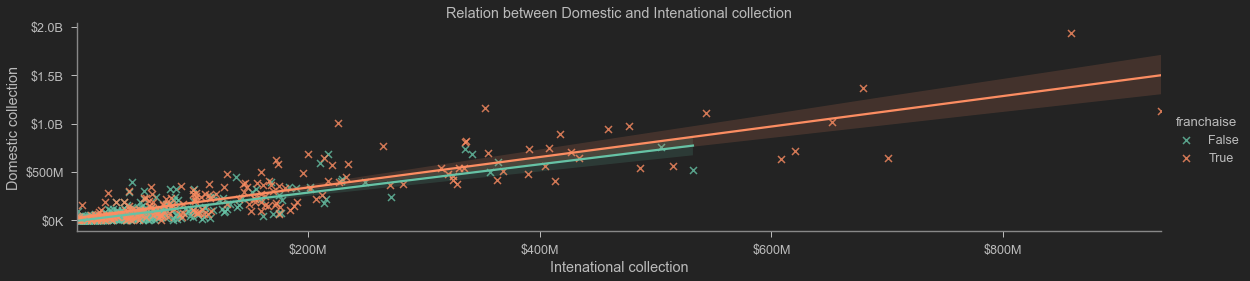

In [164]:
g = sns.lmplot(data=franchaise_df_main,
               x='vote_average',
               y='world_collection',
               hue='franchaise',
               height=4,
               aspect=4,
               palette='Set2',
               markers='x')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(format_number)

plt.title('Relation between world collection, and popularity')
plt.ylabel('World collection')
plt.xlabel("Average votes")

g = sns.lmplot(data=franchaise_df_main,
               x='dom_collection',
               y='int_collection',
               hue='franchaise',
               height=4,
               aspect=4,
               palette='Set2',
               markers='x')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(format_number)
    ax.xaxis.set_major_formatter(format_number)
plt.title(
    'Relation between Domestic and Intenational collection')
plt.ylabel('Domestic collection')
plt.xlabel("Intenational collection")

plt.show()

Franchised movies are often more popular with greater success in international market.

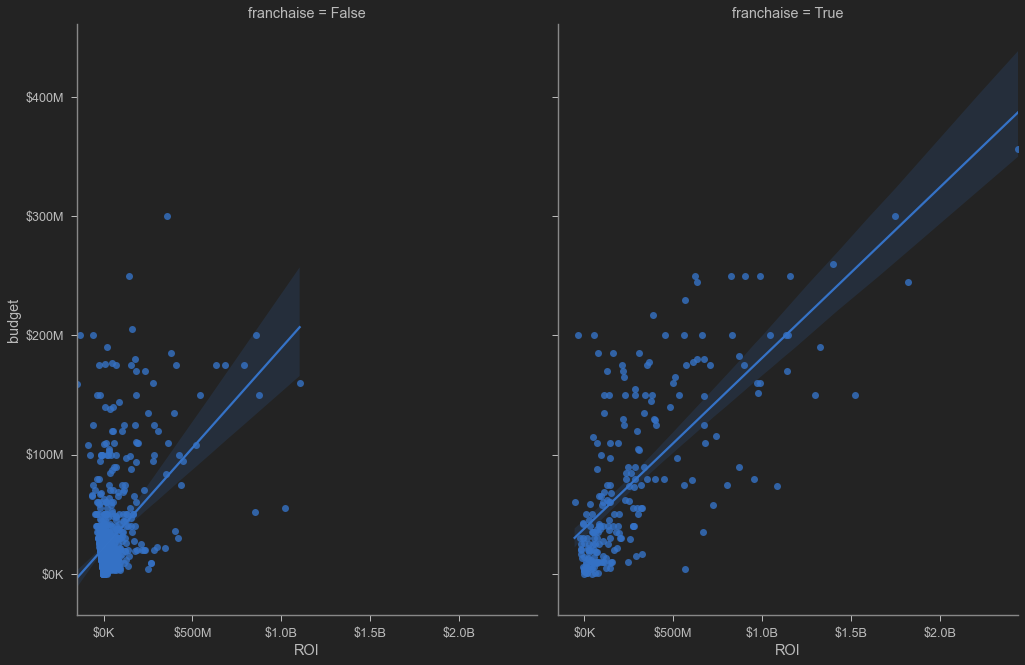

In [165]:
g = sns.FacetGrid(
   franchaise_df_main, col='franchaise', 
   height=10, aspect=.7, palette='Set2')
g.map(sns.regplot, 'ROI', 'budget')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(format_number)
    ax.xaxis.set_major_formatter(format_number)
g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle('Relationship between budget and ROI based on release timing')

Franchised movies require bigger budget but their return is also significantly higher.

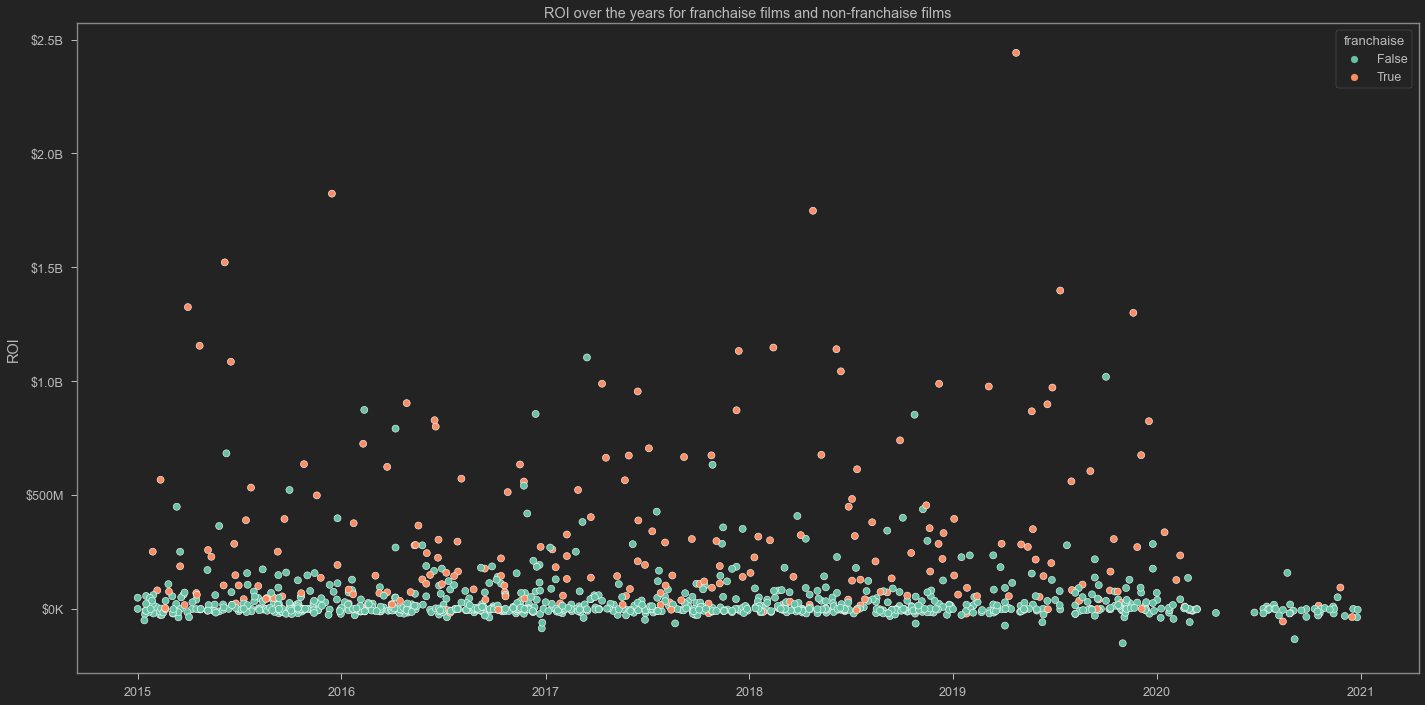

In [166]:
# ROI over the years for franchaise films and non-franchaise films
plt.figure(figsize=(20, 10))
sns.scatterplot(x='release_date',
             y='ROI',
             hue='franchaise',
             data=franchaise_df_main,
             palette='Set2',
             legend='brief').yaxis.set_major_formatter(format_number)
plt.title('ROI over the years for franchaise films and non-franchaise films')
plt.ylabel('ROI')
plt.xlabel("")
plt.tight_layout()

This straightforward time series of box office gross profit of the two categories is the simplest but most layman friendly chart that demonstrate the stark difference between them. Franchised movies are consistently outperforming the other category.

### Action suggestion

All the analysis leads towards starting a movie franchise in a shared movie universe. This must be be priority when selecting genre, director and other crew and cast. There must be option for serialization in the future. And for this Horror, Thriller, Mystery and Adventure, Action, Comedy  genre should be prioritized. It very rare that a movie falls in only one genre this days.

# Conclusion

Lets summarize and reiterate:
***
1. My recommendation is to focus for release schedule in the ***holidays season***. There is higher probability of financial and critical success for movies released in that time frame. It is relatively cheaper to make than the next best option; i.e., Summer.

2. Any one or combination of ***Action***, ***Adventure***, ***Animation*** is recommended. Animation and Action has 35% chance for occurring as genre combo. There is no landslide winner here, although this graphs can be used to figure out which one to avoid, for example western and war. 

3. All the analysis leads towards starting a ***franchise*** in a shared movie universe. This must be be priority when selecting genre, director and other crew and cast. There must be option for serialization in the future. And for this ****Horror, Thriller, Mystery**** or ****Adventure, Action, Comedy**** genre combination should be prioritized. 
    
    It very rare that a movie falls in only one genre this days.

# Next Steps

Further analyses could yield additional insights to further improve considerations for creating a new movie:
***

- Performance of **other** language movies and markets.
- Focusing on **low budget movies versus high budget movies** performance and rational.
- Movies performance in **home and international market**. 
- Recommending **lead director**.
- Recommending **movie cast** classified on genre.
- Focus only on **2020** data and find pattern and trend.

# For More Information

See the full analysis in the [Jupyter Notebook](./student.ipynb) or review this [presentation](./presentation.pdf).

# Appendix

## Most produced genre combo

In [167]:
combo_genre = main_df_raw.iloc[:,18:-1].copy()

In [168]:
combo_genre=combo_genre.corr()
combo_genre.style.background_gradient(cmap='PuRd')

In [169]:
correlation_top_bottom(combo_genre)

Positive correlations:
          index            feature_combo  correlation
0    359        Musical and Music     0.552813
1     38  Animation and Adventure     0.353164
2    316       Horror and Mystery     0.242051
3      1     Action and Adventure     0.234557
4     50    History and Biography     0.203732
5    256      Horror and Thriller     0.199766
6      7         Crime and Action     0.184287
7    255     Mystery and Thriller     0.176246
8    312     Thriller and Mystery     0.176246
9     29     Family and Adventure     0.157636

 ----------------------------------------------------------------------
       Negative correlations:
          index        feature_combo  correlation
0     65     Comedy and Drama    -0.290930
1    112  Comedy and Thriller    -0.248184
2     78  Animation and Drama    -0.203516
3    363  Drama and Animation    -0.203516
4     23  Drama and Adventure    -0.191267
5     76     Drama and Horror    -0.184330
6      3     Drama and Action    -0.155409

## Variability of profitability on different metrics

### budget vs profitability

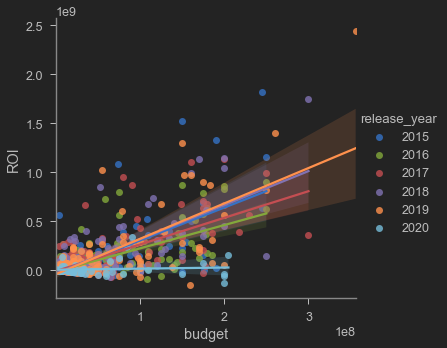

In [170]:
sns.lmplot(data=main_df, x='budget', y='ROI',hue='release_year')
plt.show()

### runtime on profitability

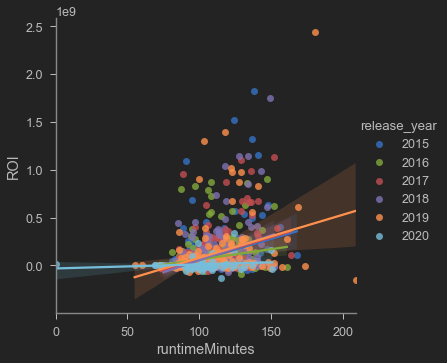

In [171]:
sns.lmplot(data=main_df, x='runtimeMinutes', y='ROI',hue='release_year')
plt.show()

### user rating on profitability

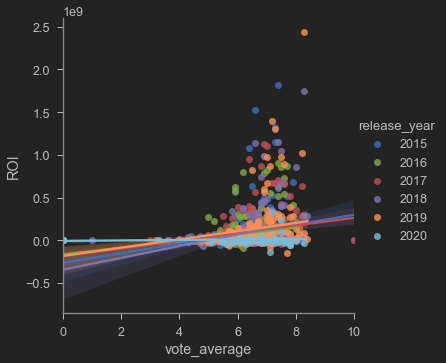

In [172]:
sns.lmplot(data=main_df, x='vote_average', y='ROI',hue='release_year')
plt.show()

### Release Timing and Profit home and abroad

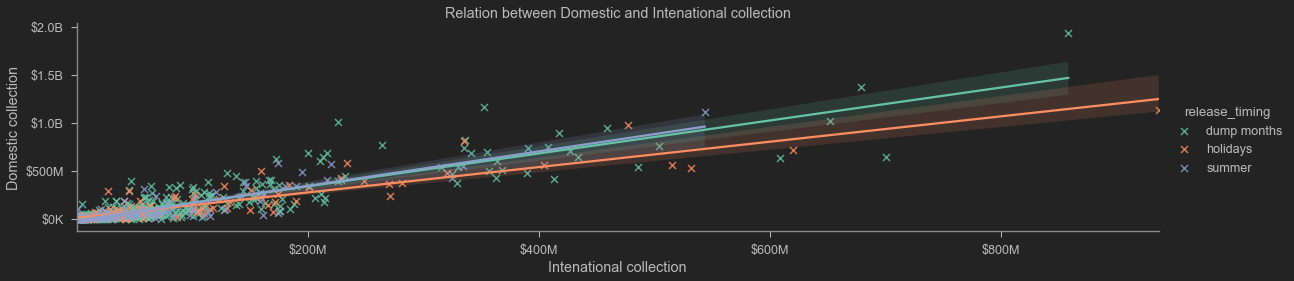

In [173]:
# Relation between Domestic and Intenational collection
g = sns.lmplot(data=timing_df,
               x='dom_collection',
               y='int_collection',
               hue='release_timing',
               height=4,
               aspect=4,
               palette='Set2',
               markers='x')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(format_number)
    ax.xaxis.set_major_formatter(format_number)
plt.title(
    'Relation between Domestic and Intenational collection')
plt.ylabel('Domestic collection')
plt.xlabel("Intenational collection")

plt.show()

Text(0.5, 0.98, 'Relation between Domestic and Intenational collection')

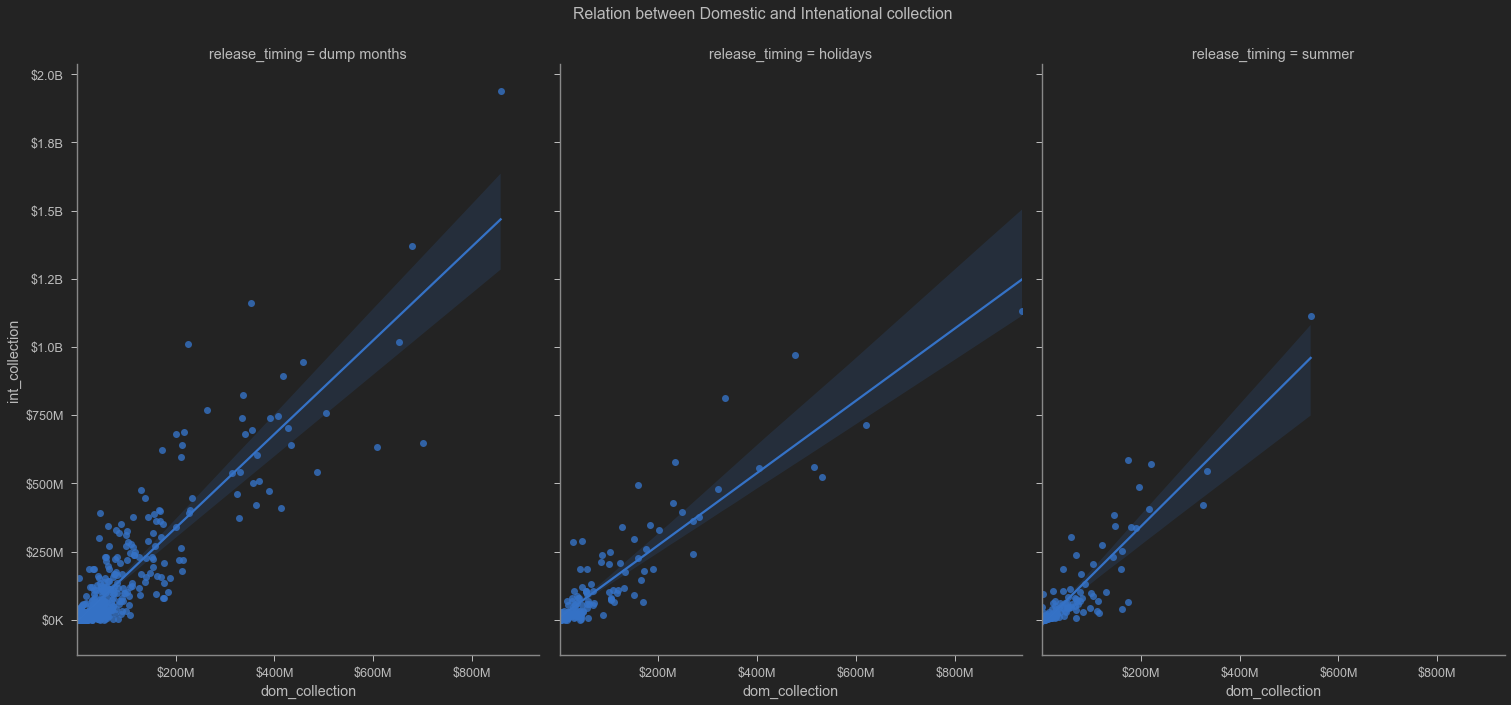

In [174]:
# Relation between Domestic and Intenational collection
g = sns.FacetGrid(
   timing_df, col='release_timing', 
   height=10, aspect=.7, palette='Set2')
g.map(sns.regplot, 'dom_collection', 'int_collection')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(format_number)
    ax.xaxis.set_major_formatter(format_number)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Relation between Domestic and Intenational collection')